# HL7 Gen v2 Synthetic Data Generation

This notebook implements a driver program for the HL7 synthetic data generation software. It also generates plots of the marginal distributions for all variables, the original and synthetic timeseries, and convergence plots for the correlation matrix elements.

## User Inputs

### 1. Specify the Jurisdiction

The jurisdiction is a <b>string</b> such as `"California"`, `"Rhode Island"`, or `"New York"`. Common state abbreviations can also be used: `"CA"`, `"RI"`, or `"NY"`. The jurisdiction string can specify one of these non-state jurisdictions as well: 

* `"American Samoa"` or `"AS"`
* `"District of Columbia"` or `"DC"`
* `"Federated States of Micronesia"` or `"FM"`
* `"Guam"` or `"GU"`
* `"Marshall Islands"` or `"MH"`
* `"New York City"` or `"NYC"`
* `"Northern Mariana Islands"` or `"MP"`
* `"Palau"` or `"PW"'
* `"Puerto Rico"` or `"PR"`
* `"Virgin Islands"` or `"VI"`

Quotation marks are required.

In [1]:
# example: JURISDICTION = "District of Columbia"
JURISDICTION = 'OR'

### 2. Specify the Condition Code

The HL7 data has been organized into a file tree with a folder for each jurisdiction. Each jurisdiction folder contains the data files for all reportable conditions in that jurisdiction. The data files are named with the condition code and a .csv extension.

The condition code should be a five-digit Python integer (only digits, no quotes).

In [2]:
# example: CONDITION_CODE = 11080
CONDITION_CODE = 10106

### 3. Condition Grouping

The data for some conditions should be combined with the data for related conditions. For instance, the data for all hemorrhagic fevers in a given jurisdiction should be combined together prior to synthetic data generation.

The default behavior is to group datasets according to the CDC's specifications. Use the `DISABLE_GROUPING` Boolean variable to disable dataset grouping. A Python Boolean variable is either `True` or `False` (no quotes).

In [3]:
# Set DISABLE_GROUPING = True to DISABLE grouping of datasets.
# Set DISABLE_GROUPING = False to ENABLE grouping of datasets.
# The command-line program has DISABLE_GROUPING = False as the default.
DISABLE_GROUPING = False

#### Special Handling for Syphilis

The synthetic data generation software can determine the data to be grouped for every condition *except* Syphilis. These Syphilis codes:

* `(10310): Syphilis, total primary and secondary`
* `(10311): Syphilis, primary`
* `(10312): Syphilis, secondary`

can be members of either these two groups:

* `Group 1: Syphilis Primary and Secondary: {10310, 10311, 10312}`
* `Group 2: Syphilis Total: {10310, 10311, 10312, 10313, 10314, 10316, 10319, 10320}`

<b>IF</b> one of the codes `10310`, `10311`, or `10312` has been specified with the `CONDITION_CODE` variable, use the `SYPHILIS_TOTAL` Boolean to indicate whether  the `Syphilis Total` grouping is desired or not.

This Boolean variable is ignored if `ENABLE_GROUPING = False`, as well as for any codes other than `10310`, `10311`, and `10312`.

In [4]:
# Set SYPHILIS_TOTAL = False for Group 1
# Set SYPHILIS_TOTAL = True for Group 2
# The command-line program has SYPHILIS_TOTAL = False as the default.
SYPHILIS_TOTAL = True

### 4. Specify the Output File Name

The synthetic data will be written to a file in the `OUTPUT_DIR` folder (see below). The format can be either CSV or JSON, with CSV being the default format. The next variable is a string that specifies the name of this output file (no extension needed). Since this is a Python string, surround it with either single or double quotes.

If an output file name is not specified, a default name will be generated according to this format: `synthetic_<code_list>_<jurisdiction>.csv`.

For instance, the default output file name for Dengue (code 10680) in California is `synthetic_10680_ca.csv`.

The default output file name for Syphilis Group 1 (codes 10310, 10311, and 10312) in California is `synthetic_10310_10311_10312_ca.csv`, assuming data for all three codes exists for this jurisdiction. If no data for code 10310 is present, the default name is `synthetic_10311_10312_ca.csv`.

The default output file name for Syphilis Group 2 in California is `synthetic_syphilis_total_ca.csv`.

To use the default name, set the variable `OUTPUT_FILE_NAME` to the special Python value `None` (no quotes).

In [5]:
# To use the default system-generated name:      OUTPUT_FILE_NAME = None
# To override the system-generated name:         OUTPUT_FILE_NAME = "my_file_name.csv" or "my_file_name.json"
# (If the name is anything other than the python special value None, quotes are required.)
# The supported output formats are CSV and JSON. If the extension is omitted the format will default to CSV.
OUTPUT_FILE_NAME = None

### 5. Optional Inputs

These variables will rarely need to be changed after configuring them for the initial run.

In [6]:
# path to the root folder of the HS7 file tree, Python string, need quotes
#HL7_DIR = "../synthetic_samples"
HL7_DIR = "/data/csels/preprocessed_data/hl7_update"

# Path to the directory in which to write the output file.
# *** This directory must exist - the code will not create it. ***
# The default is to write all output to a subdirectory of the current dir called 'synthetic_results_hl7'.
# This is a Python string, so quotes are required.
OUTPUT_DIR = "synthetic_results_hl7"

# [OPTIONAL]
# Specify the number of synthetic data samples to generate. The default is to generate as many
# samples as the synthetic timeseries requires (NUM_SAMPLES = None). This default can be overridden
# by specifying a positive integer for NUM_SAMPLES, such as NUM_SAMPLES = 65536.
# The command-line program has NUM_SAMPLES = None as the default.
NUM_SAMPLES = None

# [OPTIONAL]
# Set the seed value for the random number generator with RNG_SEED.
# If you need repeatability from run to run, set this value to an integer, such as RNG_SEED = 42.
# The command-line program has RNG_SEED = None as the default, in which case the RNG is seeded from the system time.
RNG_SEED = None

# [OPTIONAL]
# Set DEBUG = True to enable debug output, Debug = False otherwise.
# The command-line program has DEBUG = False as the default.
DEBUG = False

# END OF USER INPUTS

All code below this point runs without additional user input.

To run the notebook and generate synthetic data for the given condition and jurisdiction: from the `Kernel` menu, select `Restart & Clear Output`, then select  `Restart & Run All`.

#### Import Required Libraries

An import section is standard for all Python programs. Here we import basic system libraries, numpy, plotting routines, and several custom modules developed for this project.

In [7]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

# support modules
from src import ecdf
from src import timeseries
from src import hl7 as HL7
from src import plots_hl7 as plots
from src import correlation_matrix
from src import model_data_hl7 as data
from src import pseudoperson as pseudo
from src import synthetic_data_model as model

#### Enable Debug Output

If the user wants debug output it is enabled first:

In [8]:
if DEBUG:
    data.enable_debug()
    model.enable_debug()
    timeseries.enable_debug()

#### Construct the List of Input Files

The next task is to use the user-specified variables to determine a list of files to be loaded and processed.

We use the condition code to find out if grouping is required, and if so, to obtain all codes for the grouped conditions.

In [9]:
code_list = [CONDITION_CODE]
if not DISABLE_GROUPING:
    code_list = model.get_grouped_codes(CONDITION_CODE, SYPHILIS_TOTAL)
print('Code group: {0}'.format(code_list))

Code group: [10106]


Next we use the list of codes to construct a list of fully-qualified input filepaths:

In [10]:
infile_list = model.build_input_filepaths(HL7_DIR, JURISDICTION, code_list)    
if 0 == len(infile_list):
    print('*** No data in jurisdiction "{0}" for codes {1}. ***'.format(JURISDICTION, code_list))
    raise SystemExit()

# print the list of input files
print('Input files:')
for f in infile_list:
    print('\t{0}'.format(f))

Input files:
	/data/csels/preprocessed_data/hl7_update/Oregon/10106.csv


#### Construct the Path to the Output File

The next task is to take the supplied output file name and construct a proper Python path for it. A `.csv` extension will be added if not already present.

In [11]:
EXT_CSV  = '.csv'
EXT_JSON = '.json'
    
if OUTPUT_FILE_NAME is None:
    # no user-specified name, so use default name and CSV format
    OUTPUT_FILE_NAME = model.default_output_file_name(JURISDICTION,
                                                      code_list,
                                                      SYPHILIS_TOTAL)
else:
    # check the file extension and set to CSV if none was specified
    fullname, ext = os.path.splitext(OUTPUT_FILE_NAME)
    if ext is None:
        # no extension specified, so default to CSV format
        OUTPUT_FILE_NAME += EXT_CSV
    else:
        ext = ext.lower()
        if EXT_CSV != ext and EXT_JSON != ext:
            print('*** ERROR: Unsupported format for output file: "{0}". ***'.format(ext))
            print('Supported extensions are {0} and {1}'.format(EXT_CSV, EXT_JSON))
            raise SystemExit('FATAL ERROR: unsupported output file format')

if OUTPUT_DIR is None:
    OUTPUT_DIR = model.default_output_dir(netss_outdir = False)

output_file_path = model.build_output_filepath(OUTPUT_DIR, OUTPUT_FILE_NAME)
if output_file_path is None:
    raise SystemExit("FATAL ERROR: build_output_filepath")
    
print('Output file: \n\t{0}'.format(output_file_path))

Output file: 
	/home/richard/repos/csels/notebooks/synthetic_results_hl7/synthetic_10106_or.csv


#### Initialize the Random Number Generator

Create the RNG and seed it either from the supplied seed or from the system entropy pool:

In [12]:
rng = model.init_rng(RNG_SEED)

#### Check the Sample Count

In [13]:
if NUM_SAMPLES is not None and NUM_SAMPLES <= 0:
    raise SystemExit('FATAL ERROR: NUM_SAMPLES must be a postive integer.')

## BEGIN SYNTHETIC DATA GENERATION

The first thing to do is to capture the start time:

In [14]:
start_time = time.time()

#### Load Input Files

The next step is to load and merge the input files, initialize all data structures, etc. A full model will be created and initialized. The file loader prints information about the data after loading.

In [15]:
# these are the variables for the copula model; dates are handled separately
variable_names_in = [
    HL7.NAME_AGE,
    HL7.NAME_SEX,
    HL7.NAME_RACE,
    HL7.NAME_ETHNICITY,
    HL7.NAME_CASE_STATUS,
    HL7.NAME_COUNTY,
    HL7.NAME_PREGNANT
]

variable_names, tau_original, cdf_list, file_data = data.init_model_data(infile_list, variable_names_in, rng)
if variable_names is None or len(variable_names_in) != len(variable_names):
    model.error_exit(rng, 'init_model_data')
    
# check the output fields, which must match the header in the preprocessed data

# list of header strings used in each preprocessed csv file, all lower case
header_list = data.get_preprocessed_header()
if len(header_list) != len(HL7.OUTPUT_FIELDS):
        print('*** Invalid output fields ***')
        print('preprocessed file header strings: ')
        print(header_list)
        print('HL7 output filelds: ')
        print(HL7.OUTPUT_FIELDS)
        raise SystemExit()

for i,f in enumerate(HL7.OUTPUT_FIELDS):
    if header_list[i] != HL7.OUTPUT_FIELDS[i]:
            print('*** Invalid output fields ***')
            print('\tFrom header list: "{0}"'.format(header_list[i]))
            print('\tFrom HL7.OUTPUT_FIELDS: "{0}"'.format(HL7.OUTPUT_FIELDS[i]))
            raise SystemExit()

Information for file "/data/csels/preprocessed_data/hl7_update/Oregon/10106.csv":
	      Start Elect Submit Date: 2016-01-01
	        End Elect Submit Date: 2021-02-28
	Line count (excluding header): 28967
	  Lines with complete records: 26576
	      Sum of all count fields: 26576
	        Lines with COUNT == 0:   752
	           NOT_A_CASE entries:  1618
	 RESULTS_NOT_OBTAINED entries:    21
	    No. of different counties:    38
	                  Bad records:     0
	          Missing AGE entries:     0
	    Missing AGE_UNITS entries:     0
	  Unhandled AGE_UNITS entries:     0
	          Missing SEX entries:    23
	         Missing RACE entries:     0
	    Missing ETHNICITY entries:     0
	       Missing COUNTY entries:     0
	  Missing CASE_STATUS entries:     0
	     Missing PREGNANT entries: 19907
	          Invalid SEX entries:     4
	         Invalid RACE entries:     0
	    Invalid ETHNICITY entries:     0
	  Invalid CASE_STATUS entries:     0
	     Invalid PREGNANT entries:   

#### Plot Marginal Distributions

It is helpful to look at plots of the marginal distributions for each variable. These plots reveal whether any categorical variables are concentrated in only a few values, indicating that those variables may be essentially uncorrelated with the others.

The `AGE` and `COUNTY` plots are drawn much larger than the other plots, to overcome any resolution artifacts. The `AGE` variable has 122 possibilities, and the `COUNTY` variable could have as many as 255 values for the state of Texas.

The `AGE_UNKNOWN` value has been remapped from 999 to -1, to make it contiguous with the other `AGE` values.

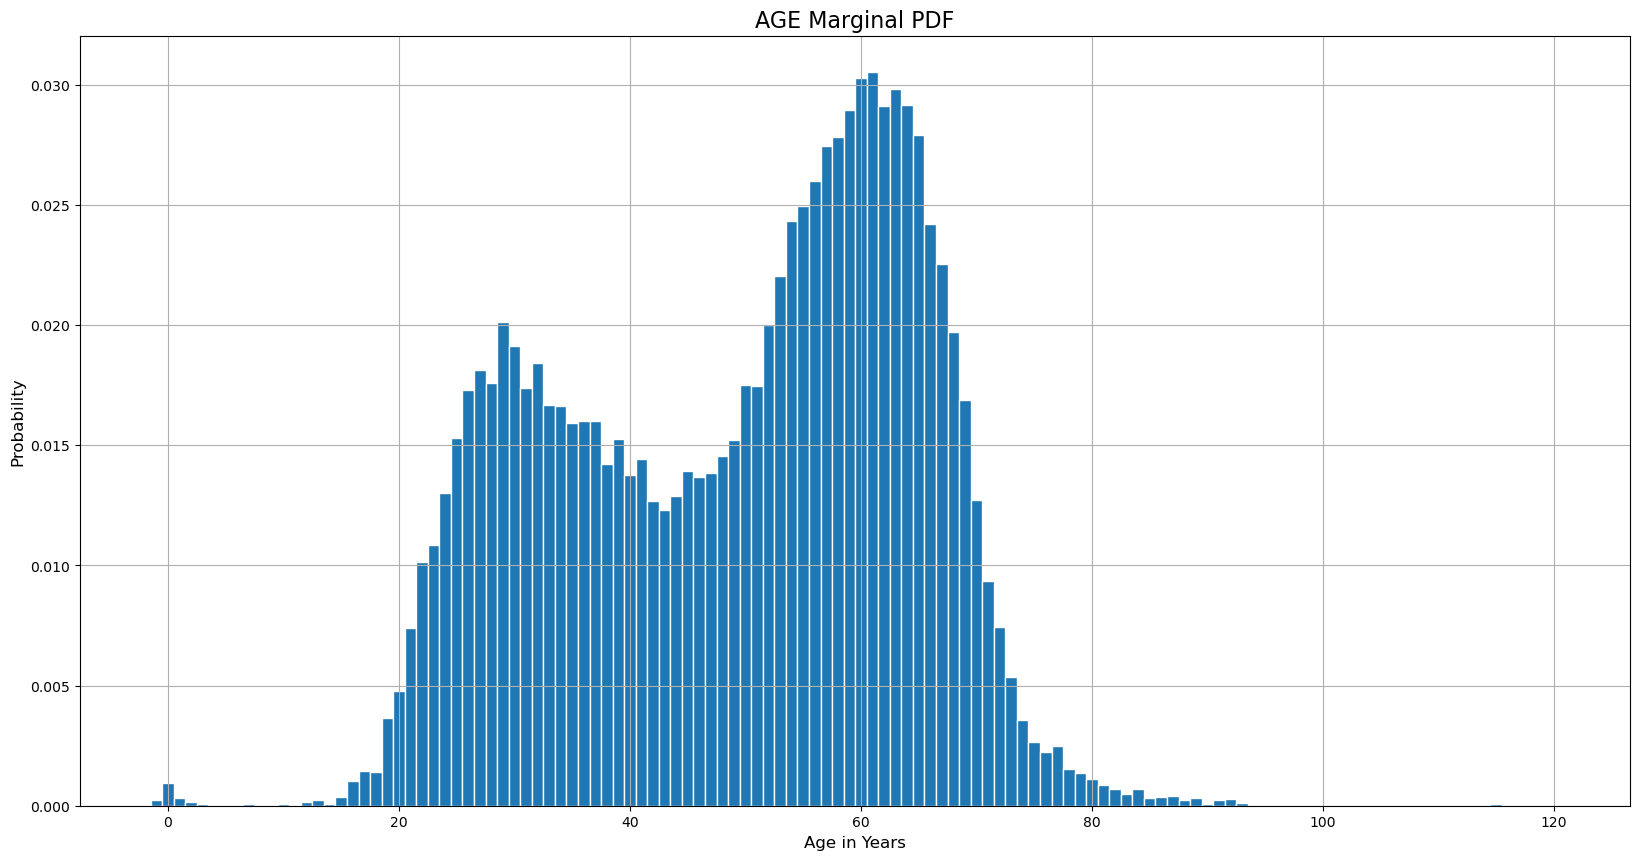

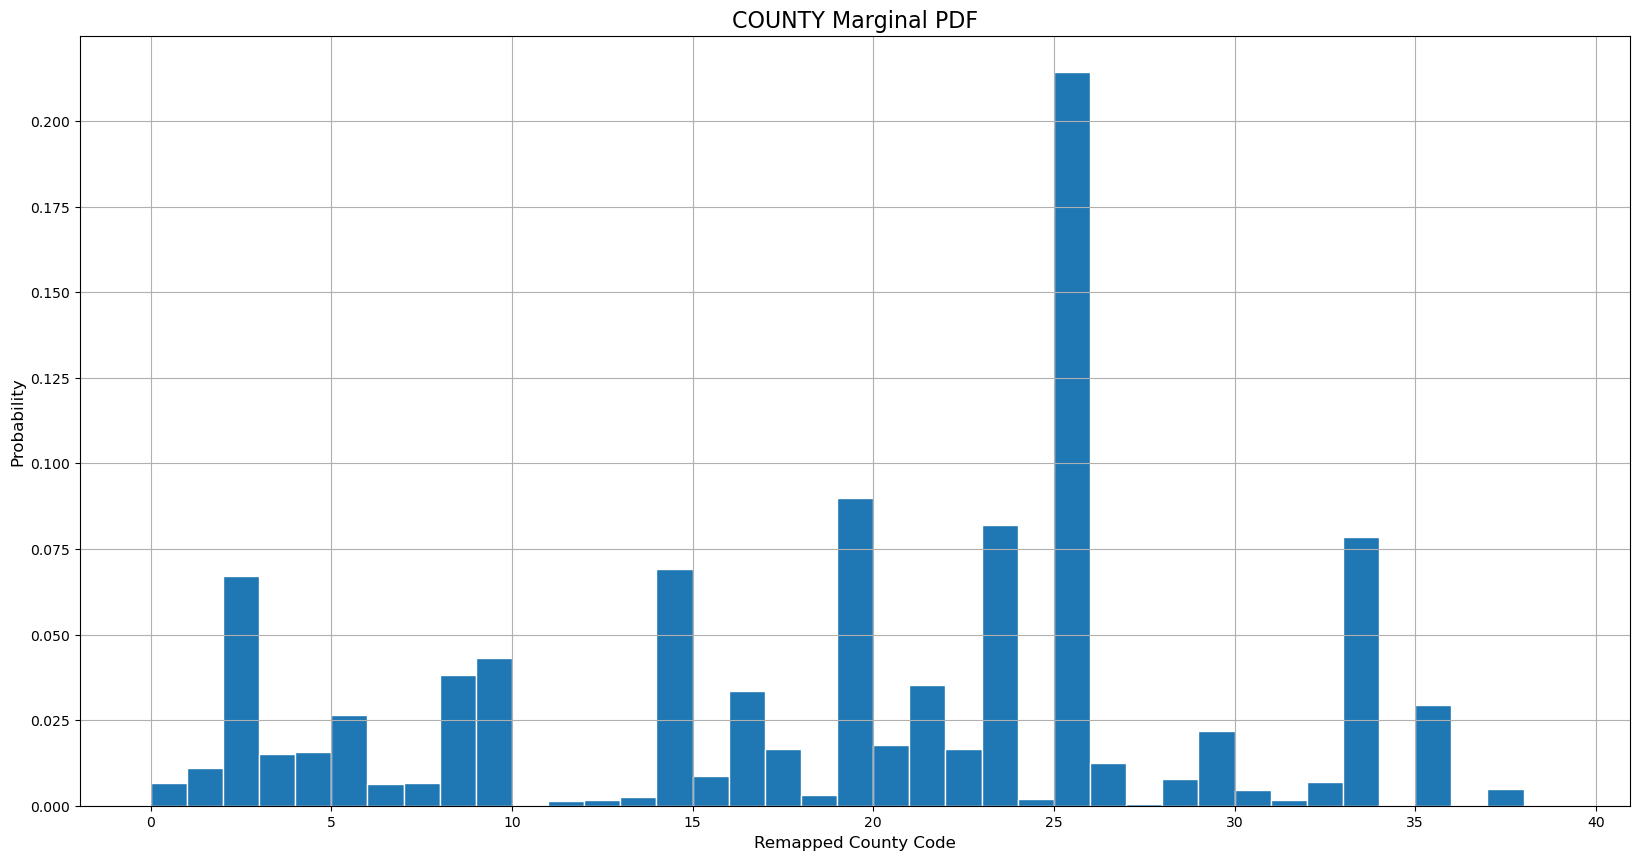

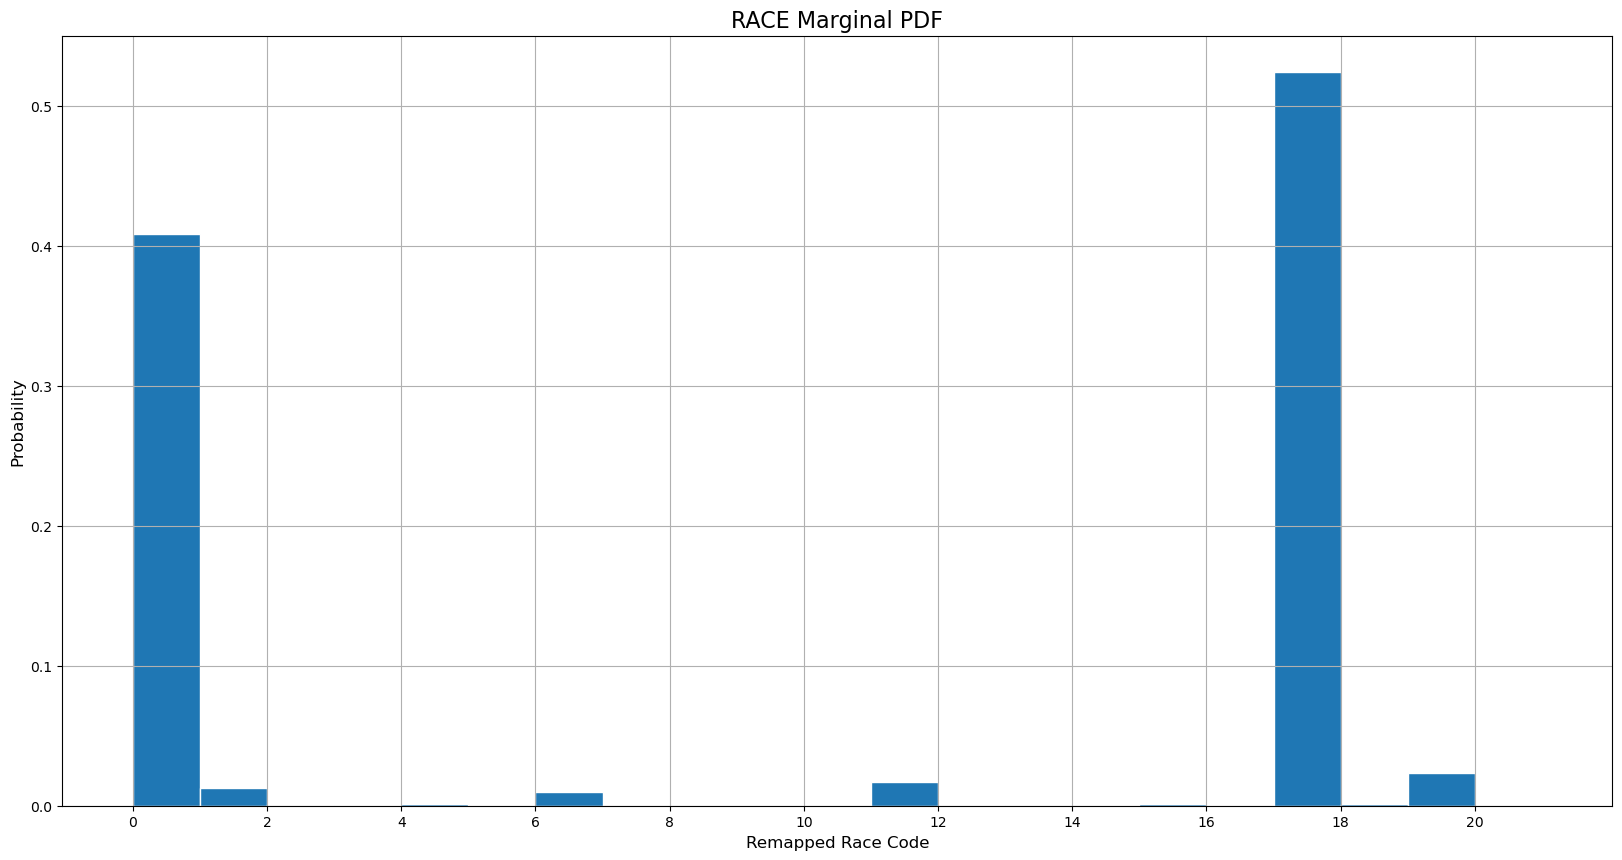

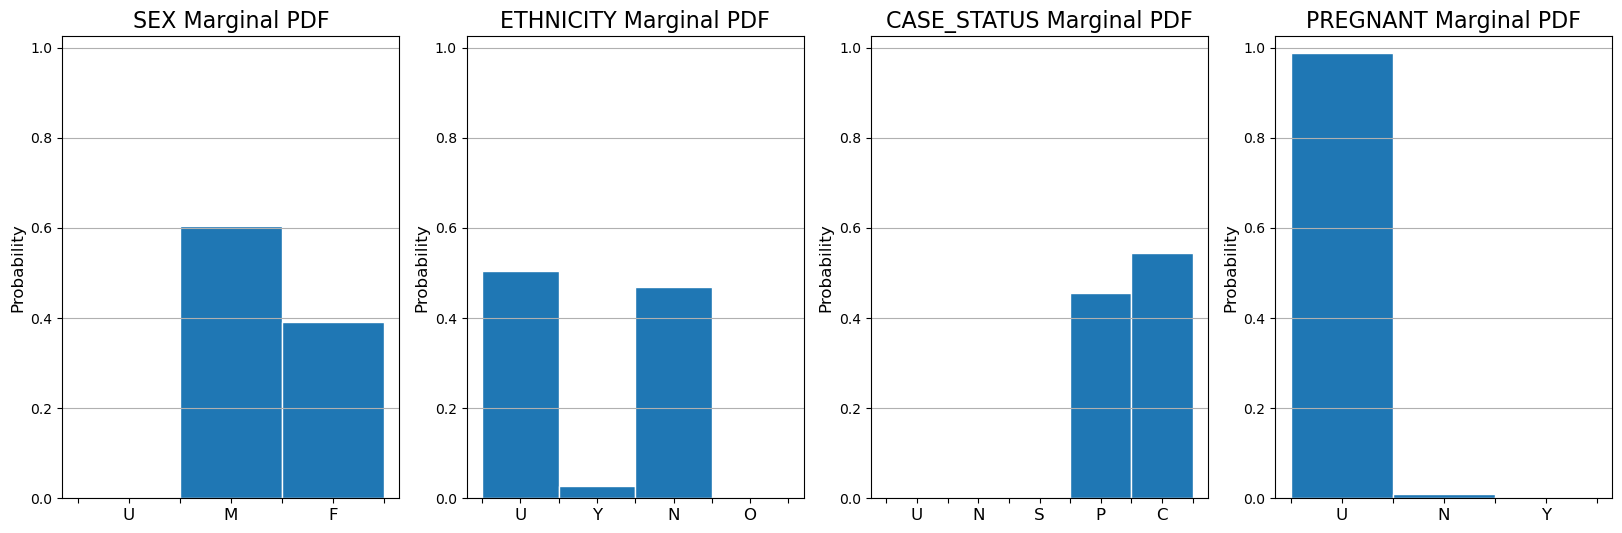

In [16]:
data.plot_marginal_distributions()

#### Plot the Empirical Cumulative Distribution Functions and their Inverses

It is also instructive to look at the empirical cumulative distribution functions (ECDF) and their inverses. The copula model uses the inverse ECDFs to partition the values for each categorical variable appropriately. The ECDF and inverse ECDF functions should all be monotonic, smooth, and well-behaved.

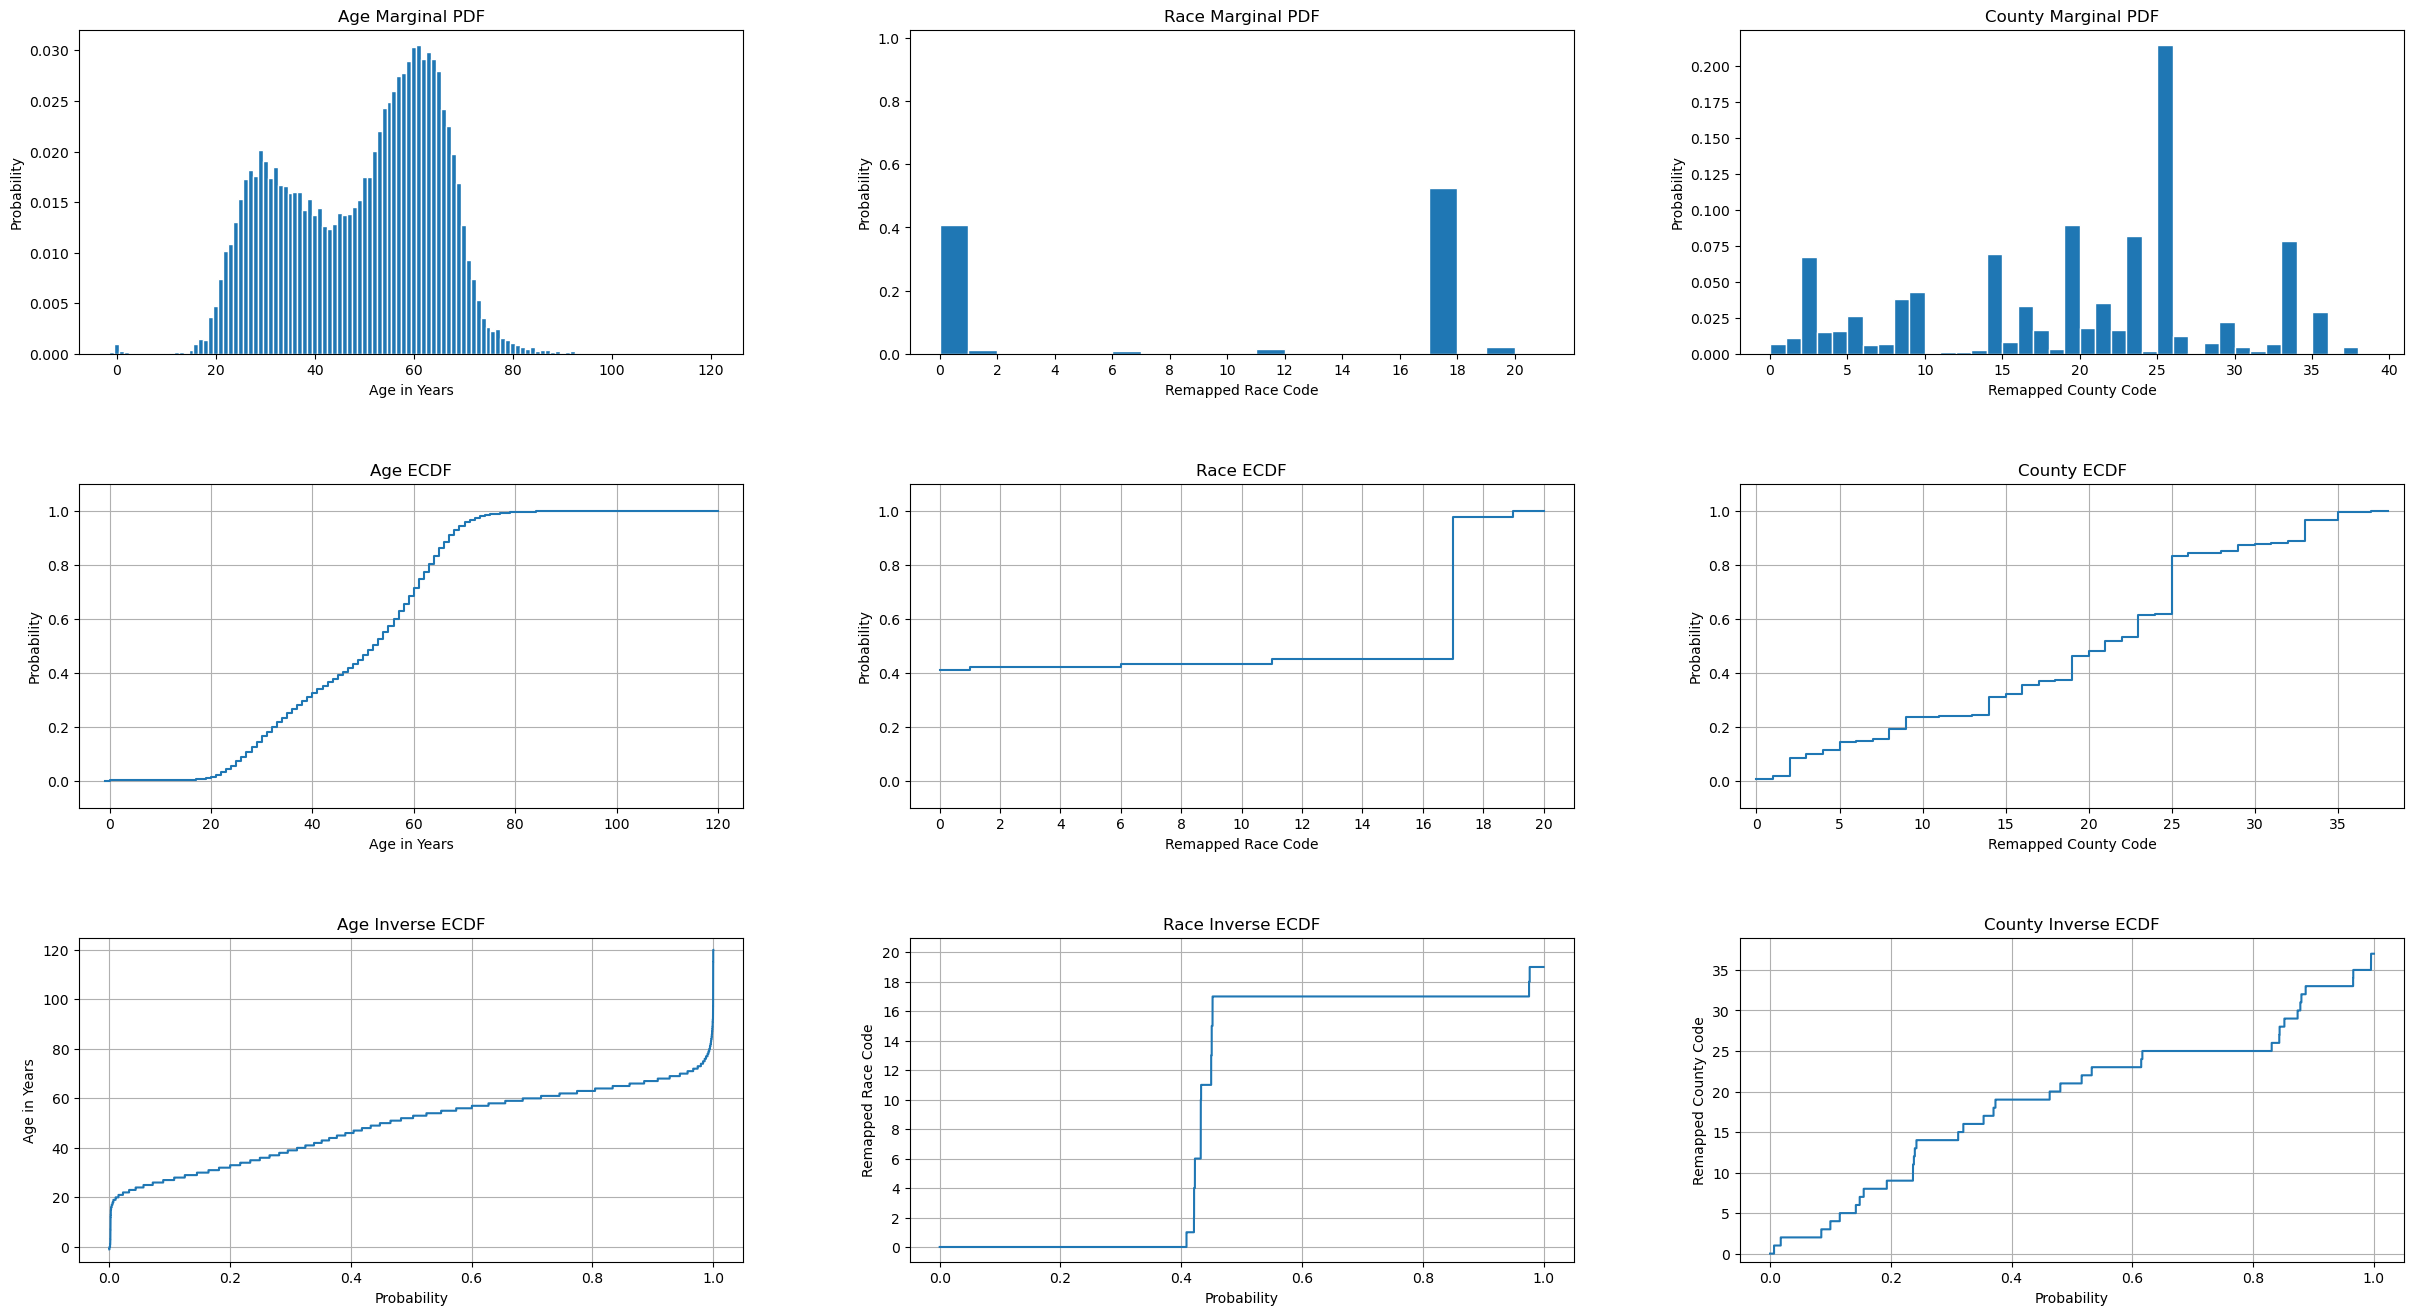

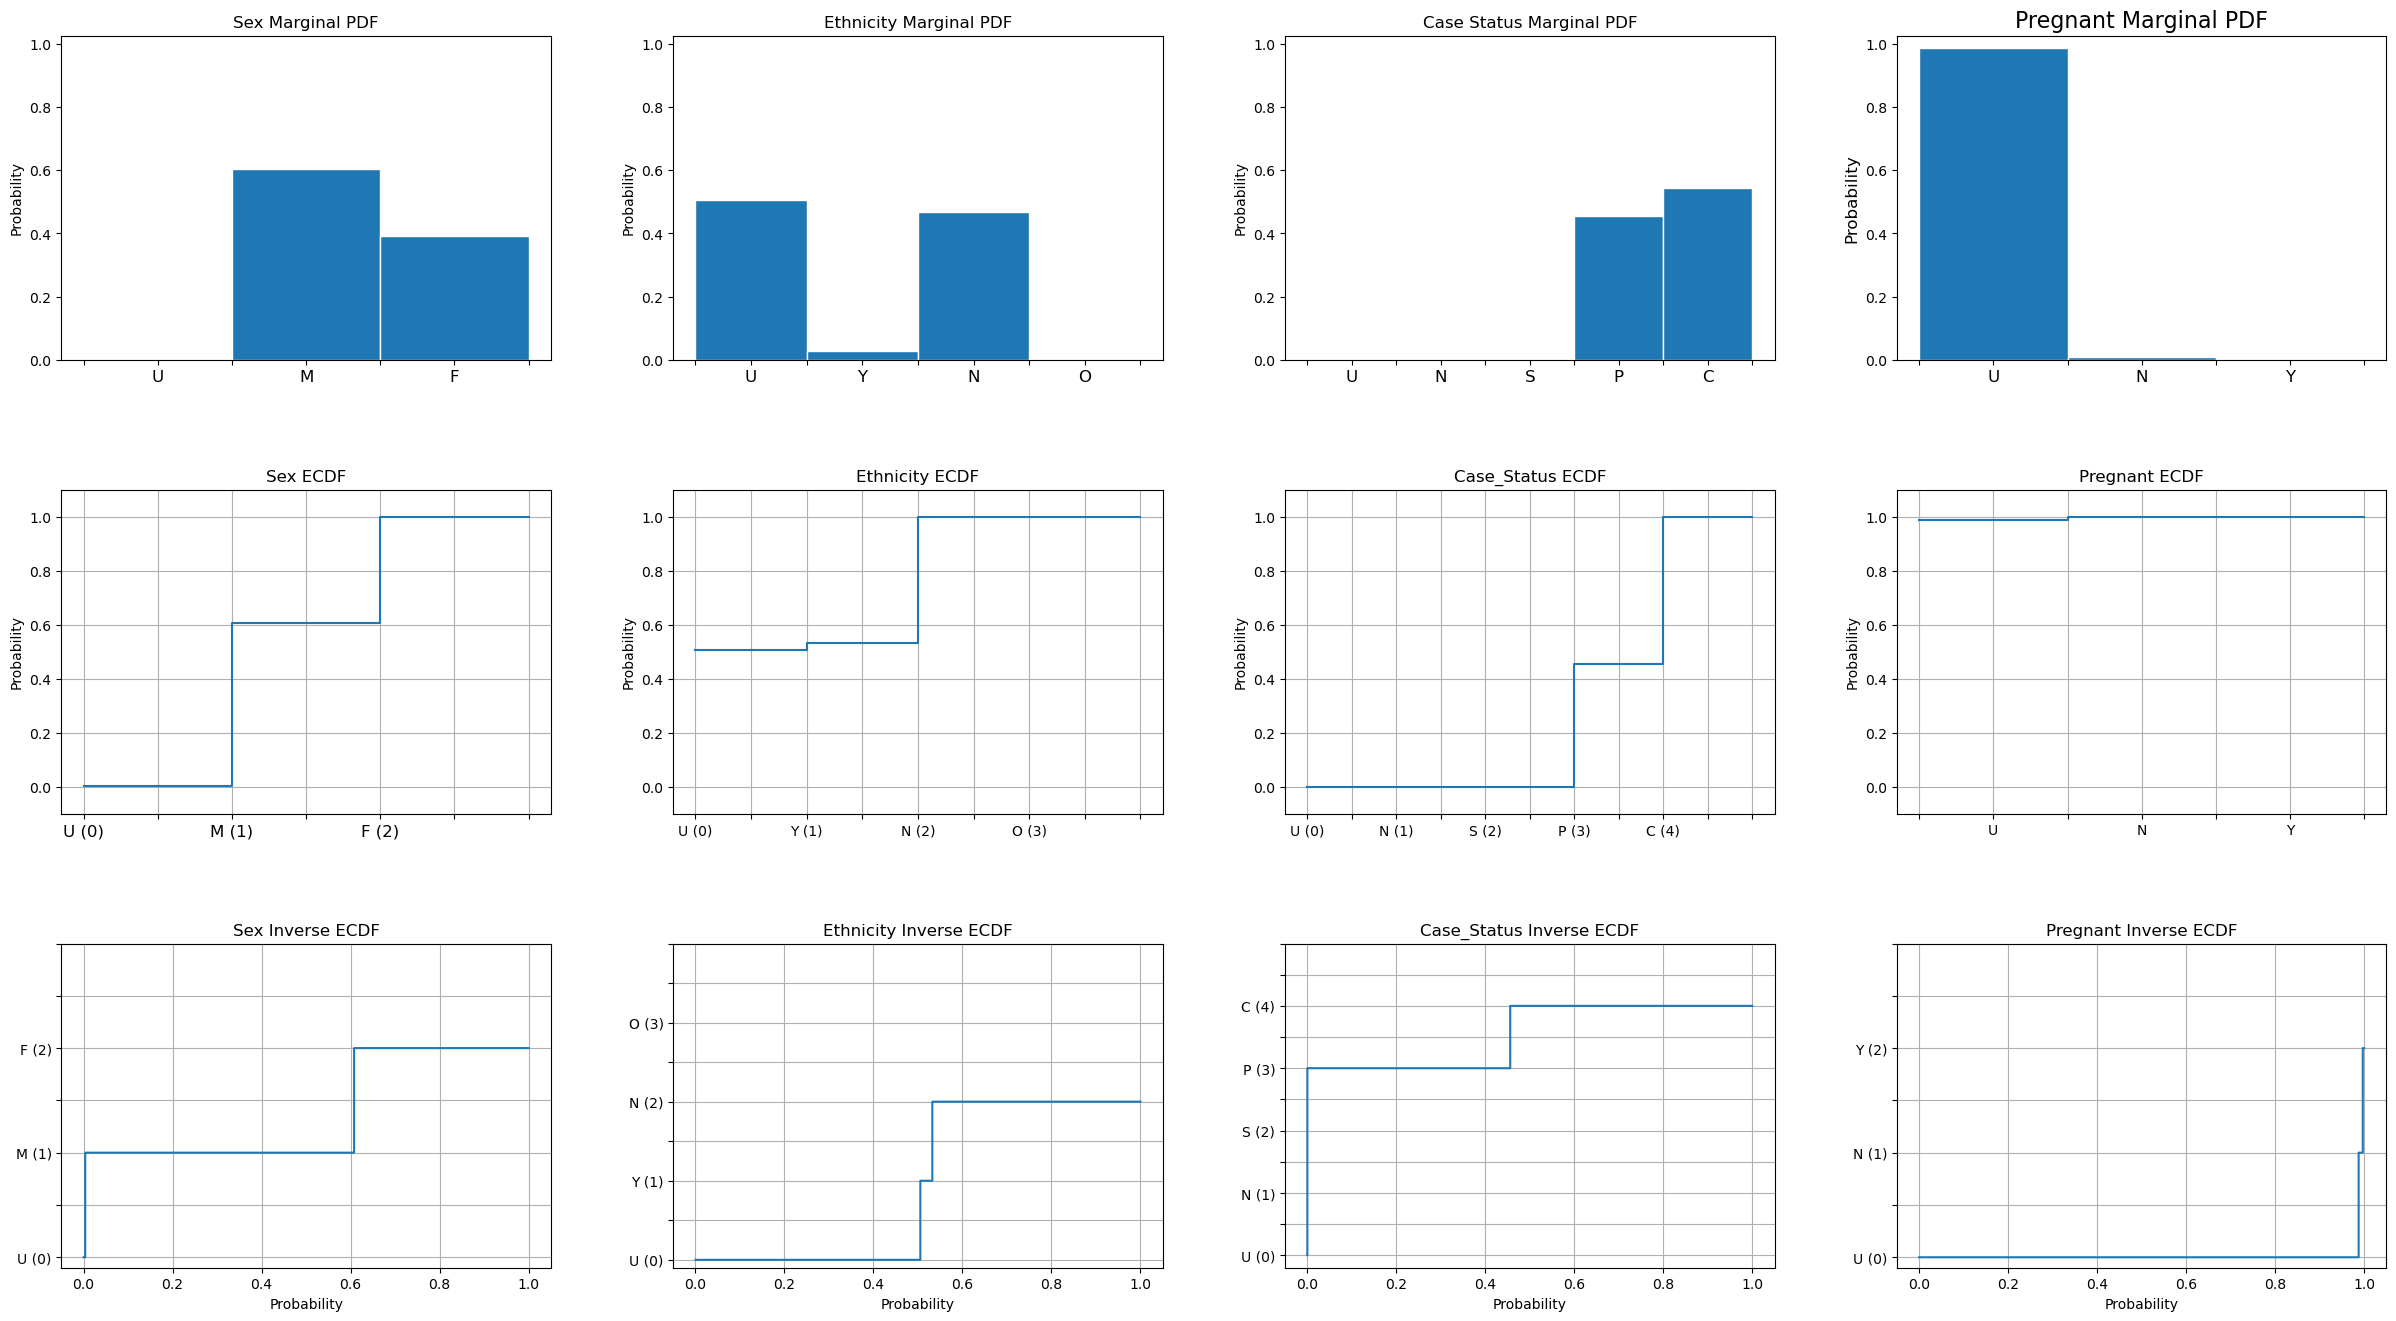

In [17]:
data.plot_pdf_ecdf()

## Signal Processing

With the data successfully loaded the synthetic timeseries can be generated.

In [18]:
# save start time for signal processing
signal_processing_start_time = time.time()

The next function computes the number of case reports per day from the available data. The number of case reports per day is the "signal", which will be modified by the signal processing code.

In [19]:
dates, signal, maps = data.signal_from_anchor_date(file_data)
assert len(signal) == len(dates)

# add all the counts in the signal to get the total cases
sample_count_orig = np.sum(signal)

# save the max original date, needed to write output file
str_max_date_orig = dates[-1]

print('Timeseries information: ')
print('\t     Sum of all COUNT values: {0}'.format(sample_count_orig))
print('\tNumber of days in timeseries: {0}'.format(len(signal)))

print('\nDate ranges for each map: ')
for i,m in enumerate(maps):
    map_dates = [dt for dt in m.keys()]
    if len(map_dates) > 0:
        sorted_dates = sorted(map_dates)
        m0 = sorted_dates[0]
        m1 = sorted_dates[-1]
        print('\t[{0}]: min: {1},  max: {2}'.format(i, m0, m1))

Found 26576 records with nonzero counts
Number of sorted anchor dates: 1843
Min anchor date: 2015-03-04 00:00:00, max anchor date: 2021-02-07 00:00:00, day_count: 2167
Min date from dates list: 2015-03-04
Max date from dates list: 2021-02-07
Signal information: 
	 min signal value: 0
	 max signal value: 57
	date of max value: 2017-02-21 00:00:00
Timeseries information: 
	     Sum of all COUNT values: 26576
	Number of days in timeseries: 2168

Date ranges for each map: 
	[0]: min: 2016-01-05 00:00:00,  max: 2021-02-11 00:00:00
	[1]: min: 2015-03-04 00:00:00,  max: 2021-02-09 00:00:00
	[2]: min: 2016-01-15 00:00:00,  max: 2020-08-01 00:00:00
	[3]: min: 2016-01-03 00:00:00,  max: 2021-02-09 00:00:00
	[4]: min: 2016-01-05 00:00:00,  max: 2021-02-09 00:00:00
	[5]: min: 2015-12-29 00:00:00,  max: 2021-02-07 00:00:00
	[6]: min: 2016-01-05 00:00:00,  max: 2021-02-10 00:00:00


#### Generate Synthetic Fourier Result with Adaptive Amplitude Noise

With the timeseries available, the next step is to modify it from the original by adding noise. The adaptive noise generator will vary the amount of noise based on the local characteristics of the signal.

In [20]:
# save the time when the Fourier code started
fourier_start_time = time.time()

# Generate the Fourier result using the default params. For HL7 better results
# are achieved by NOT adding phase noise to the Fourier components. Some data
# sets have long spans of zero counts, and an imperfect Fourier reconstruction
# adds too much noise to such regions.
synthetic_fourier = timeseries.gen_synthetic_fourier(rng,
                                                     timeseries=signal,
                                                     pct_to_modify=0.0)

# ensure the synthetic result spans as many days as the original
assert len(synthetic_fourier) == len(signal)

# save the time when the Fourier code finished
fourier_end_time = time.time()
fourier_elapsed = fourier_end_time - fourier_start_time

#### Modify Very Sparse Timeseries

Results for very sparse datasets can be improved by modifying the values of some of the nonzero counts and slightly changing their positions in the timeseries. The next function call performs these modifications.

In [21]:
attempts = 0
threshold_inc = 0.1
while attempts < 7:
    # perform modifications to very sparse segments
    delta = attempts * threshold_inc
    synthetic_timeseries = timeseries.modify_sparse_segments(rng,
                                                             synthetic_fourier,
                                                             delta)
    
    # compute difference signal
    diff_signal = synthetic_timeseries - signal

    # try again if no difference
    if not np.any(diff_signal):
        attempts += 1
        continue
    else:
        break
            
# this is the end of signal processing
signal_processing_end_time = time.time()

signal_processing_elapsed = signal_processing_end_time - signal_processing_start_time
print('Signal processing elapsed time: {0:.3f}s'.format(signal_processing_elapsed))
print('\tFourier synthesis time: {0:.3f}s'.format(fourier_elapsed))

Signal processing elapsed time: 1.238s
	Fourier synthesis time: 0.022s


#### Plot the Signal and the Individual Date Traces

Plots of different dates vs. time can be useful for determining the completeness of the original data. The signal derived above appears in the first subplot. Subsequent subplots show the number of case reports sharing common date values for each different date type.

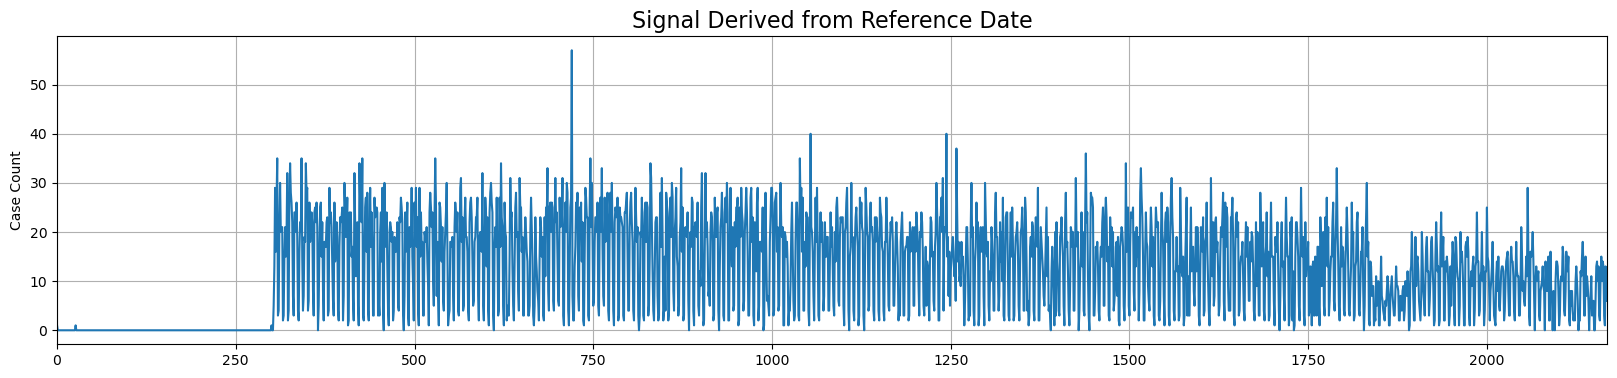

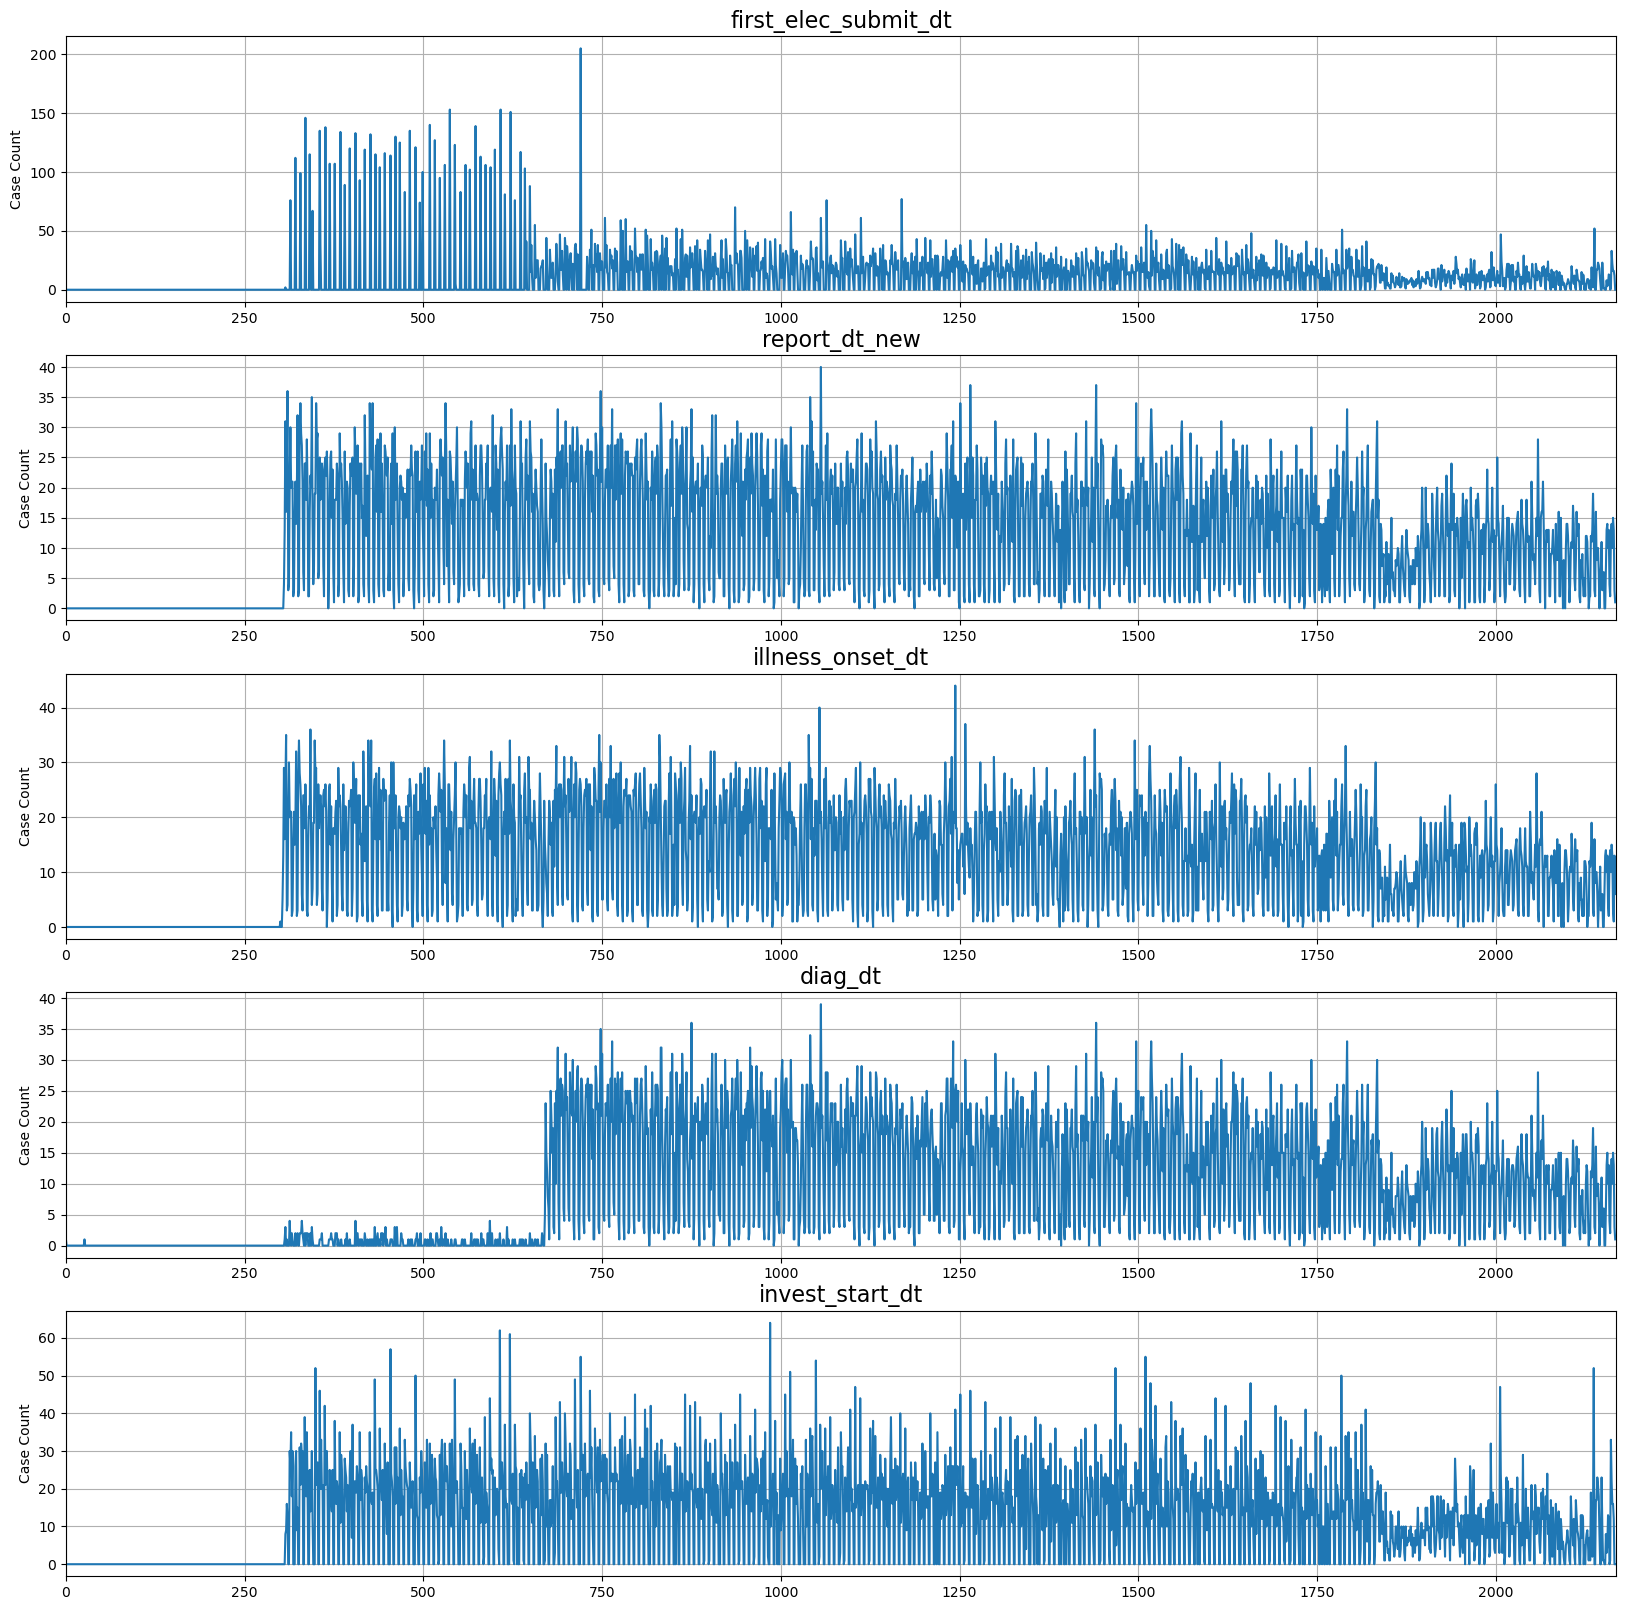

In [22]:
plots.plot_date_signals(dates, signal, maps)

#### Plot the Original and Synthetic Timeseries

It is helpful to look at a plot of the original timeseries data for the COUNT variable, along with the synthetic timeseries and a difference signal. Visual inspection of the plots reveals whether the signal processing code was successful at generating a realistic result.

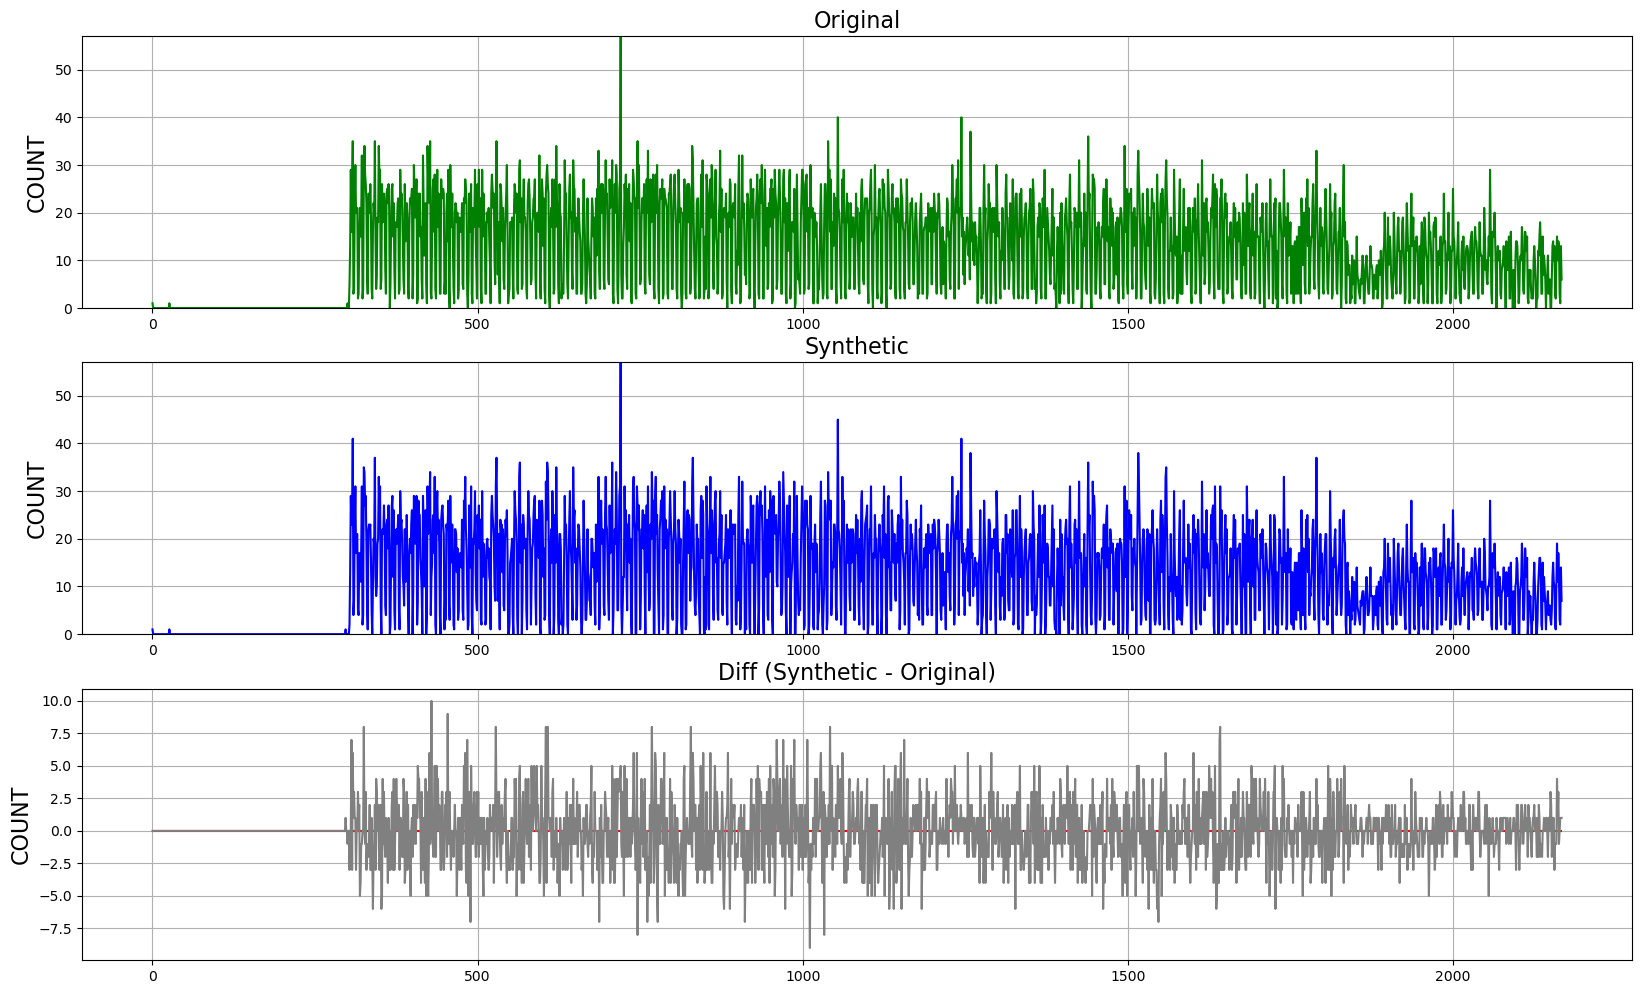

In [23]:
if signal is not None and synthetic_timeseries is not None:
    plots.plot_timeseries_result(signal, synthetic_timeseries)

#### Compute the Number of Synthetic Categorical Tuples to Generate

The synthetic timeseries provides a value of the `COUNT` variable for each day. These counts need to be summed so that the copula model will know how many synthetic categorical tuples to generate. This value can be overridden by the user if desired via the `NUM_SAMPLES` variable.

It is important to note that the sum of all COUNT values in the synthetic timeseries will likely differ from the same quantity in the original data.

In [24]:
# sum the counts in the synthetic timeseries
sample_count_synthetic = int(np.sum(synthetic_timeseries))
print(' Total counts in the original timeseries: {0}'.format(sample_count_orig))
print('Total counts in the synthetic timeseries: {0}'.format(sample_count_synthetic))

if NUM_SAMPLES is not None:
    # override with user-specified value
    sample_count_synthetic = NUM_SAMPLES

 Total counts in the original timeseries: 26576
Total counts in the synthetic timeseries: 26550


## Run the Copula Model

With the number of samples determined the copula model can run. The copula model generates tuples of synthetic values for the categorical variables.

In [25]:
print('Running copula model...')

# save the time when the copula model started
copula_start_time = time.time()

# run the copula model
synthetic_data, tau_synthetic = model.copula_n_variable_model(sample_count_synthetic,
                                                              variable_names,
                                                              tau_original,
                                                              cdf_list,
                                                              rng)

if synthetic_data is None:
    # something went wrong; the copula model code will provide info
    model.error_exit(rng, 'copula_n_variable_model')

# detect and fix any problems with pseudopersons  
print('Correcting pseudopersons...')
synthetic_data = pseudo.correct_invalid_pseudopersons(sample_count_synthetic,
                                                      variable_names,
                                                      synthetic_data,
                                                      tau_original,
                                                      cdf_list,
                                                      rng)
    
# remap the synthetic catagorical values from consecutive integers to the HL7 values
synthetic_results = data.remap_synthetic_results(synthetic_data, variable_names)

# save the end time
copula_end_time = time.time()

print('\tElapsed time: {0:.3f}s'.format(copula_end_time - copula_start_time))

Running copula model...
	Computing Kendall's tau correlation matrix...
Correcting pseudopersons...
	Found 28 invalid pseudopersons, 0.105% of the total
	Computing Kendall's tau correlation matrix...
	Found 28 of 28 needed corrections.
	Elapsed time: 23.832s


#### Generate Pseudoperson Date Tuples

The next function generates a list of date tuples from which the synthetic correlated dates will be derived. There is one entry in `date_tuple_list` for each synthetic sample.

In [26]:
date_tuple_list = data.generate_date_tuples(sample_count_synthetic,
                                            synthetic_timeseries,
                                            dates,
                                            variable_names,
                                            synthetic_results,
                                            str_max_date_orig,
                                            rng)

Generated 26550 date tuples for 26550 synthetic samples.


#### Write the Output File

At this point all synthetic data has been generated, so the output file can be written:

In [27]:
data.write_output_file(output_file_path,
                       sample_count_synthetic,
                       synthetic_timeseries,
                       dates,
                       variable_names,
                       synthetic_results,
                       str_max_date_orig,
                       date_tuple_list)
print('\nWrote output file "{0}"'.format(output_file_path))


Wrote output file "/home/richard/repos/csels/notebooks/synthetic_results_hl7/synthetic_10106_or.csv"


#### Determine Elapsed Time

It is also useful to know the overall runtime, which includes the time required to generate the plots above:

In [28]:
end_time = time.time()
print('Total elapsed time: {0:.3f}s'.format(end_time - start_time))

Total elapsed time: 38.188s


## END OF SYNTHETIC DATA GENERATION

### Load the Output File and Generate Correlation Matrix Element Convergence Plots

Checking the convergence behavior of the Kendall's tau correlation matrix elements is also useful. The plot below provides an indication of how well the rank correlations present in the original data are preserved in the synthetic data.

The code below checks the correlations for these variables: AGE, SEX, RACE, ETHNICITY, CASE_STATUS, and COUNTY. A 6D model has a 6x6 tau correlation matrix, for a total of 36 elements. The six elements along the diagonal all have the value 1.0. The matrix is also symmetric, which means that there are (36-6)/2 == 15 independent matrix elements. These elements will be plotted below in a plot containing three rows of five subplots each.

This is the procedure for generating the convergence plots:

* Load the output file containing the synthetic data
* Remap the values of the categorical variables from their HL7 values to consecutive integers
* Compute the Kendall's tau correlation matrix for sample sizes of 32, 64, 128, 256, ..., max_samples
* Plot the values of each matrix element vs. sample size

#### Load the Output File and Build Data Structures

In [29]:
print('Loading synthetic data from file {0}'.format(output_file_path))
variable_names, tau_synth, cdf_list, file_data = data.init_model_data([output_file_path], variable_names_in)
if variable_names is None or len(variable_names_in) != len(variable_names):
    model.error_exit(rng, 'init_model_data')
    
# build data arrays
age_data       = []
sex_data       = []
race_data      = []
ethnicity_data = []
casstat_data   = []
county_data    = []
pregnant_data  = []

# Remap the synthetic categorical data from the HL7 values to consecutive integers. This remapping
# is needed to compare the synthetic Kendall's tau matrix with the original, which was computed from
# the remapped data.
remapped_data = data.get_remapped_data(variable_names)

for i, name in enumerate(variable_names):
    if HL7.NAME_AGE == name:
        age_data = remapped_data[i]
    elif HL7.NAME_SEX == name:
        sex_data = remapped_data[i]
    elif HL7.NAME_RACE == name:
        race_data = remapped_data[i]
    elif HL7.NAME_ETHNICITY == name:
        hispanic_data = remapped_data[i]
    elif HL7.NAME_CASE_STATUS == name:
        casstat_data = remapped_data[i]
    elif HL7.NAME_COUNTY == name:
        county_data = remapped_data[i]
    elif HL7.NAME_PREGNANT == name:
        pregnant_data = remapped_data[i]

# length of the synthetic data arrays
max_samples = len(age_data)

Loading synthetic data from file /home/richard/repos/csels/notebooks/synthetic_results_hl7/synthetic_10106_or.csv
Information for file "/home/richard/repos/csels/notebooks/synthetic_results_hl7/synthetic_10106_or.csv":
	      Start Elect Submit Date: 2015-03-09
	        End Elect Submit Date: 2021-02-14
	Line count (excluding header): 26962
	  Lines with complete records: 26550
	      Sum of all count fields: 26550
	        Lines with COUNT == 0:   412
	           NOT_A_CASE entries:     0
	 RESULTS_NOT_OBTAINED entries:     0
	    No. of different counties:    38
	                  Bad records:     0
	          Missing AGE entries:     0
	    Missing AGE_UNITS entries:     0
	  Unhandled AGE_UNITS entries:     0
	          Missing SEX entries:     0
	         Missing RACE entries:     0
	    Missing ETHNICITY entries:     0
	       Missing COUNTY entries:     0
	  Missing CASE_STATUS entries:     0
	     Missing PREGNANT entries: 16061
	          Invalid SEX entries:     0
	         I

#### Plot the Marginal Distributions for the Synthetic Data

The marginal distributions for the synthetic data should look <b>*similar*</b> to those of the original data set. The similarity increases as the number of synthetic data samples increases. 

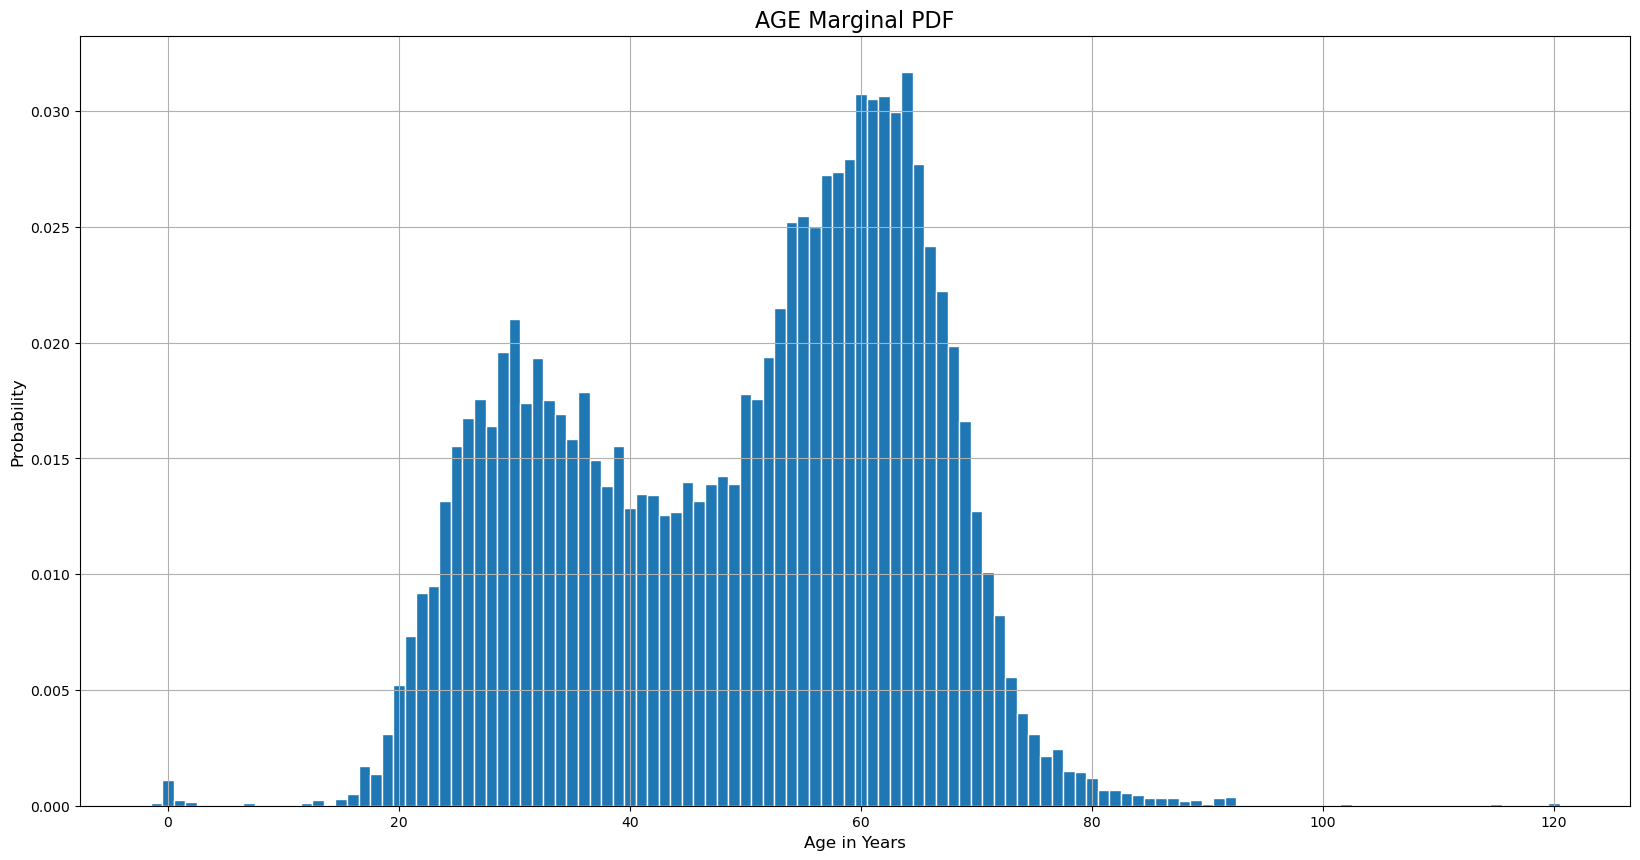

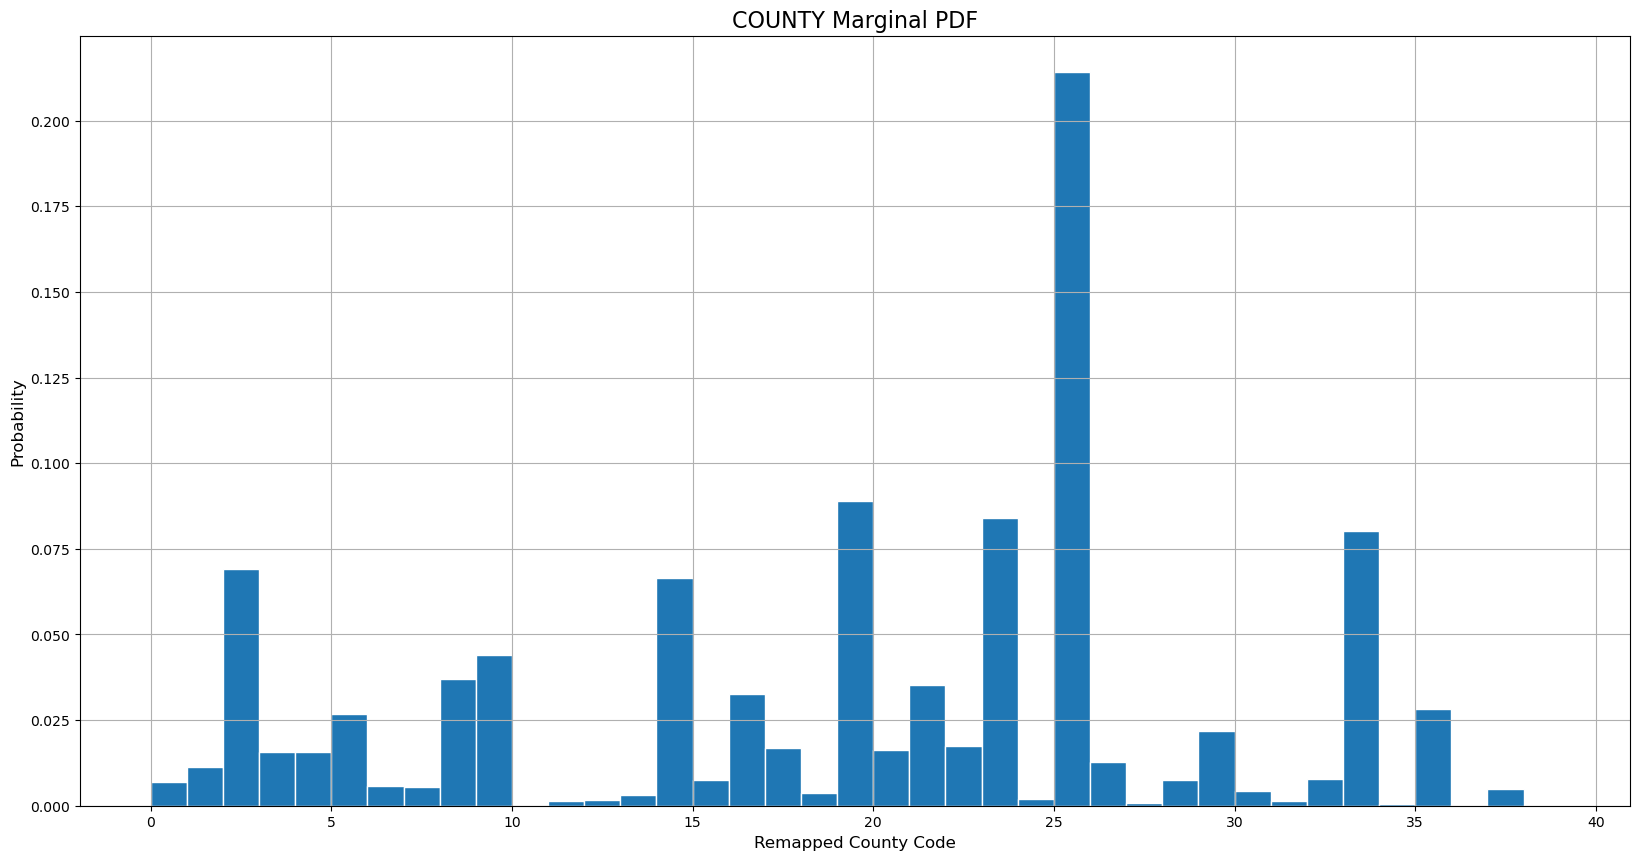

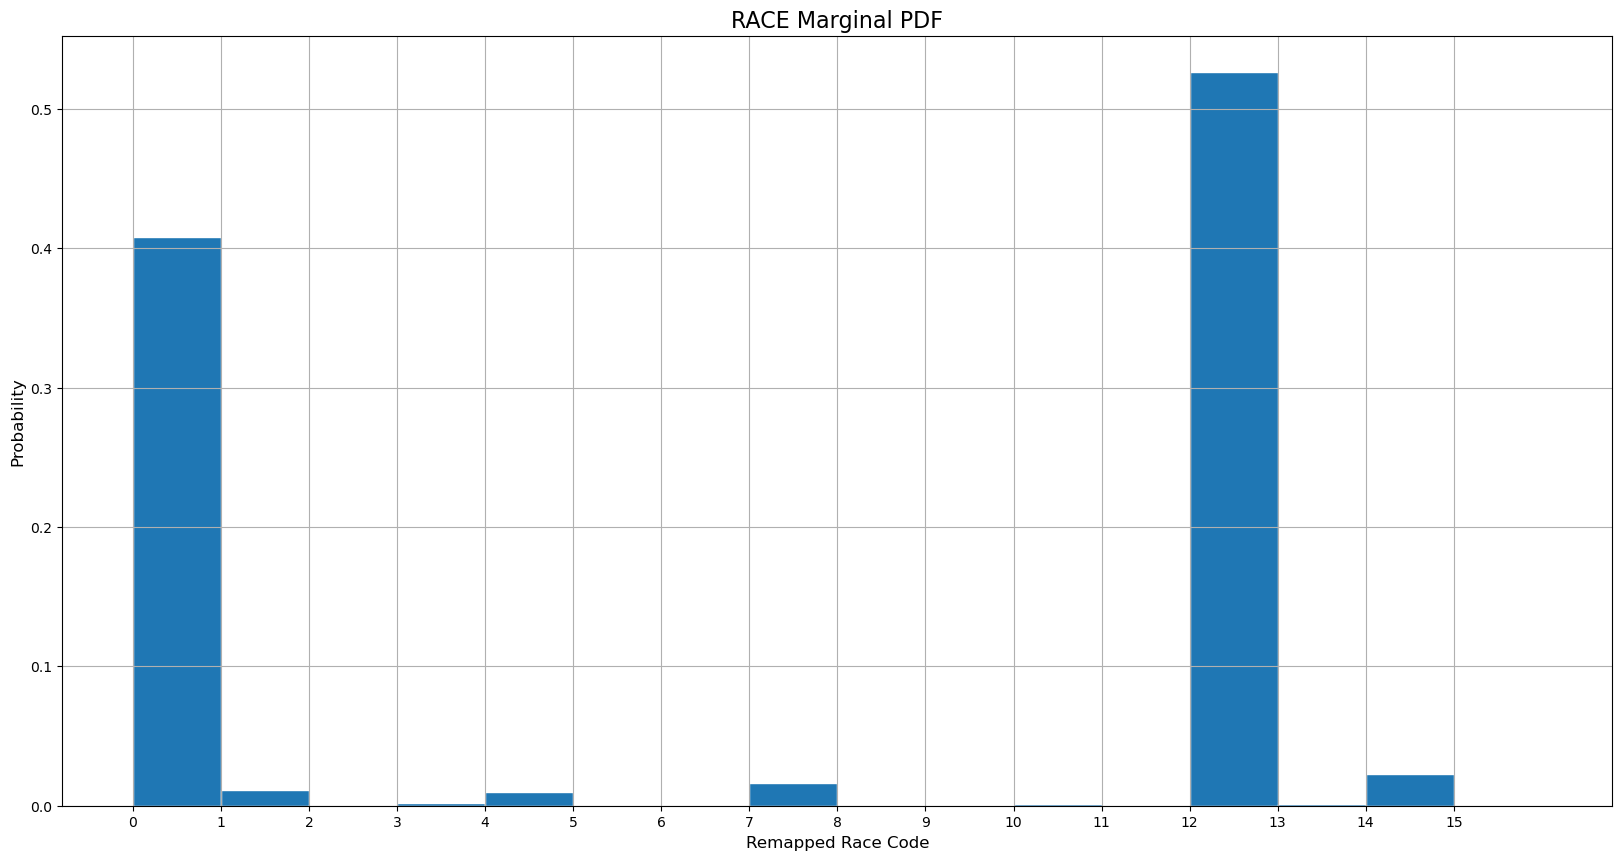

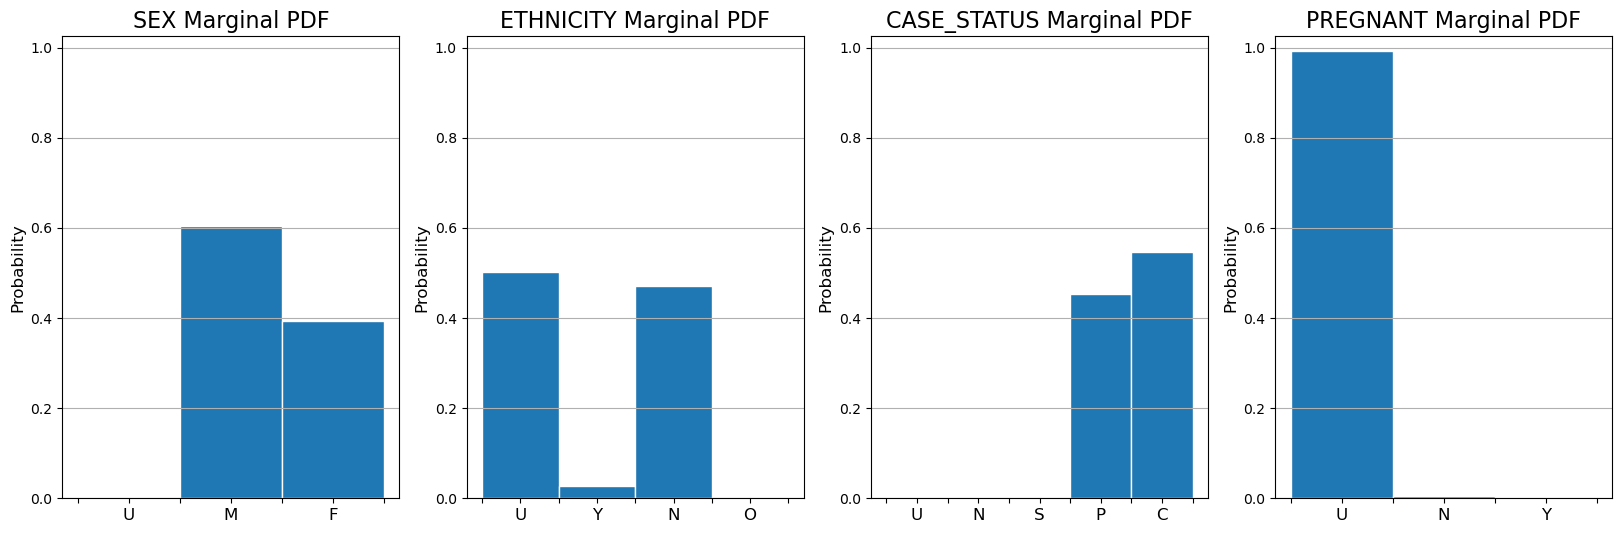

In [30]:
data.plot_marginal_distributions()

#### Plot the Empirical Cumulative Distribution Functions and their Inverses for the Synthetic Data

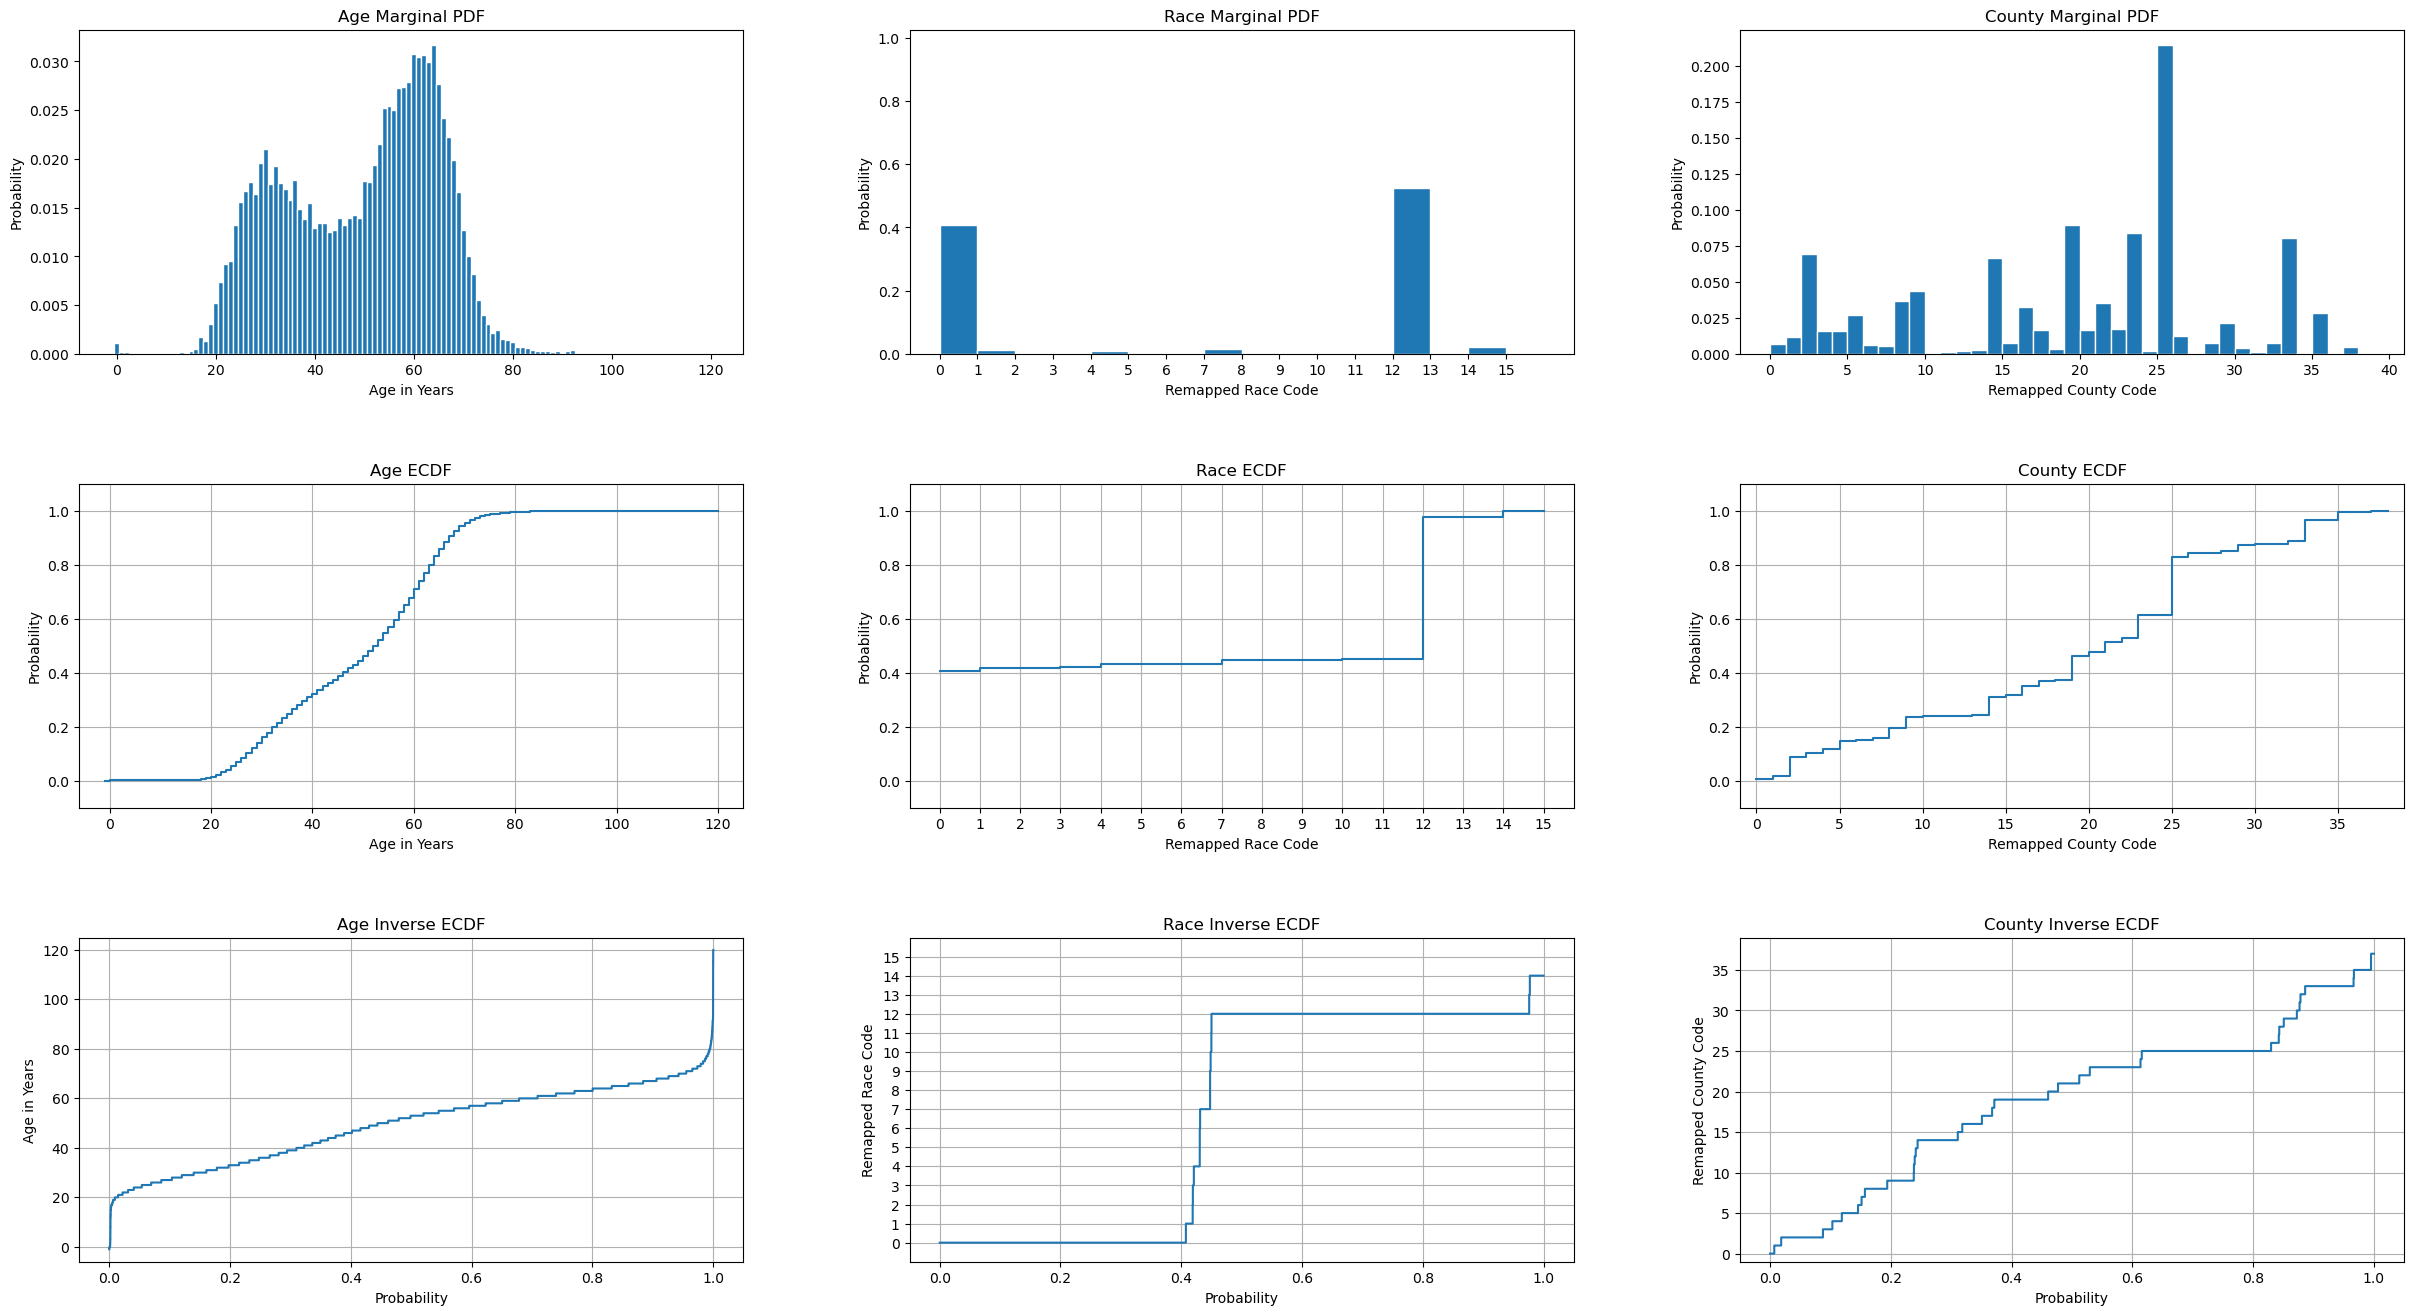

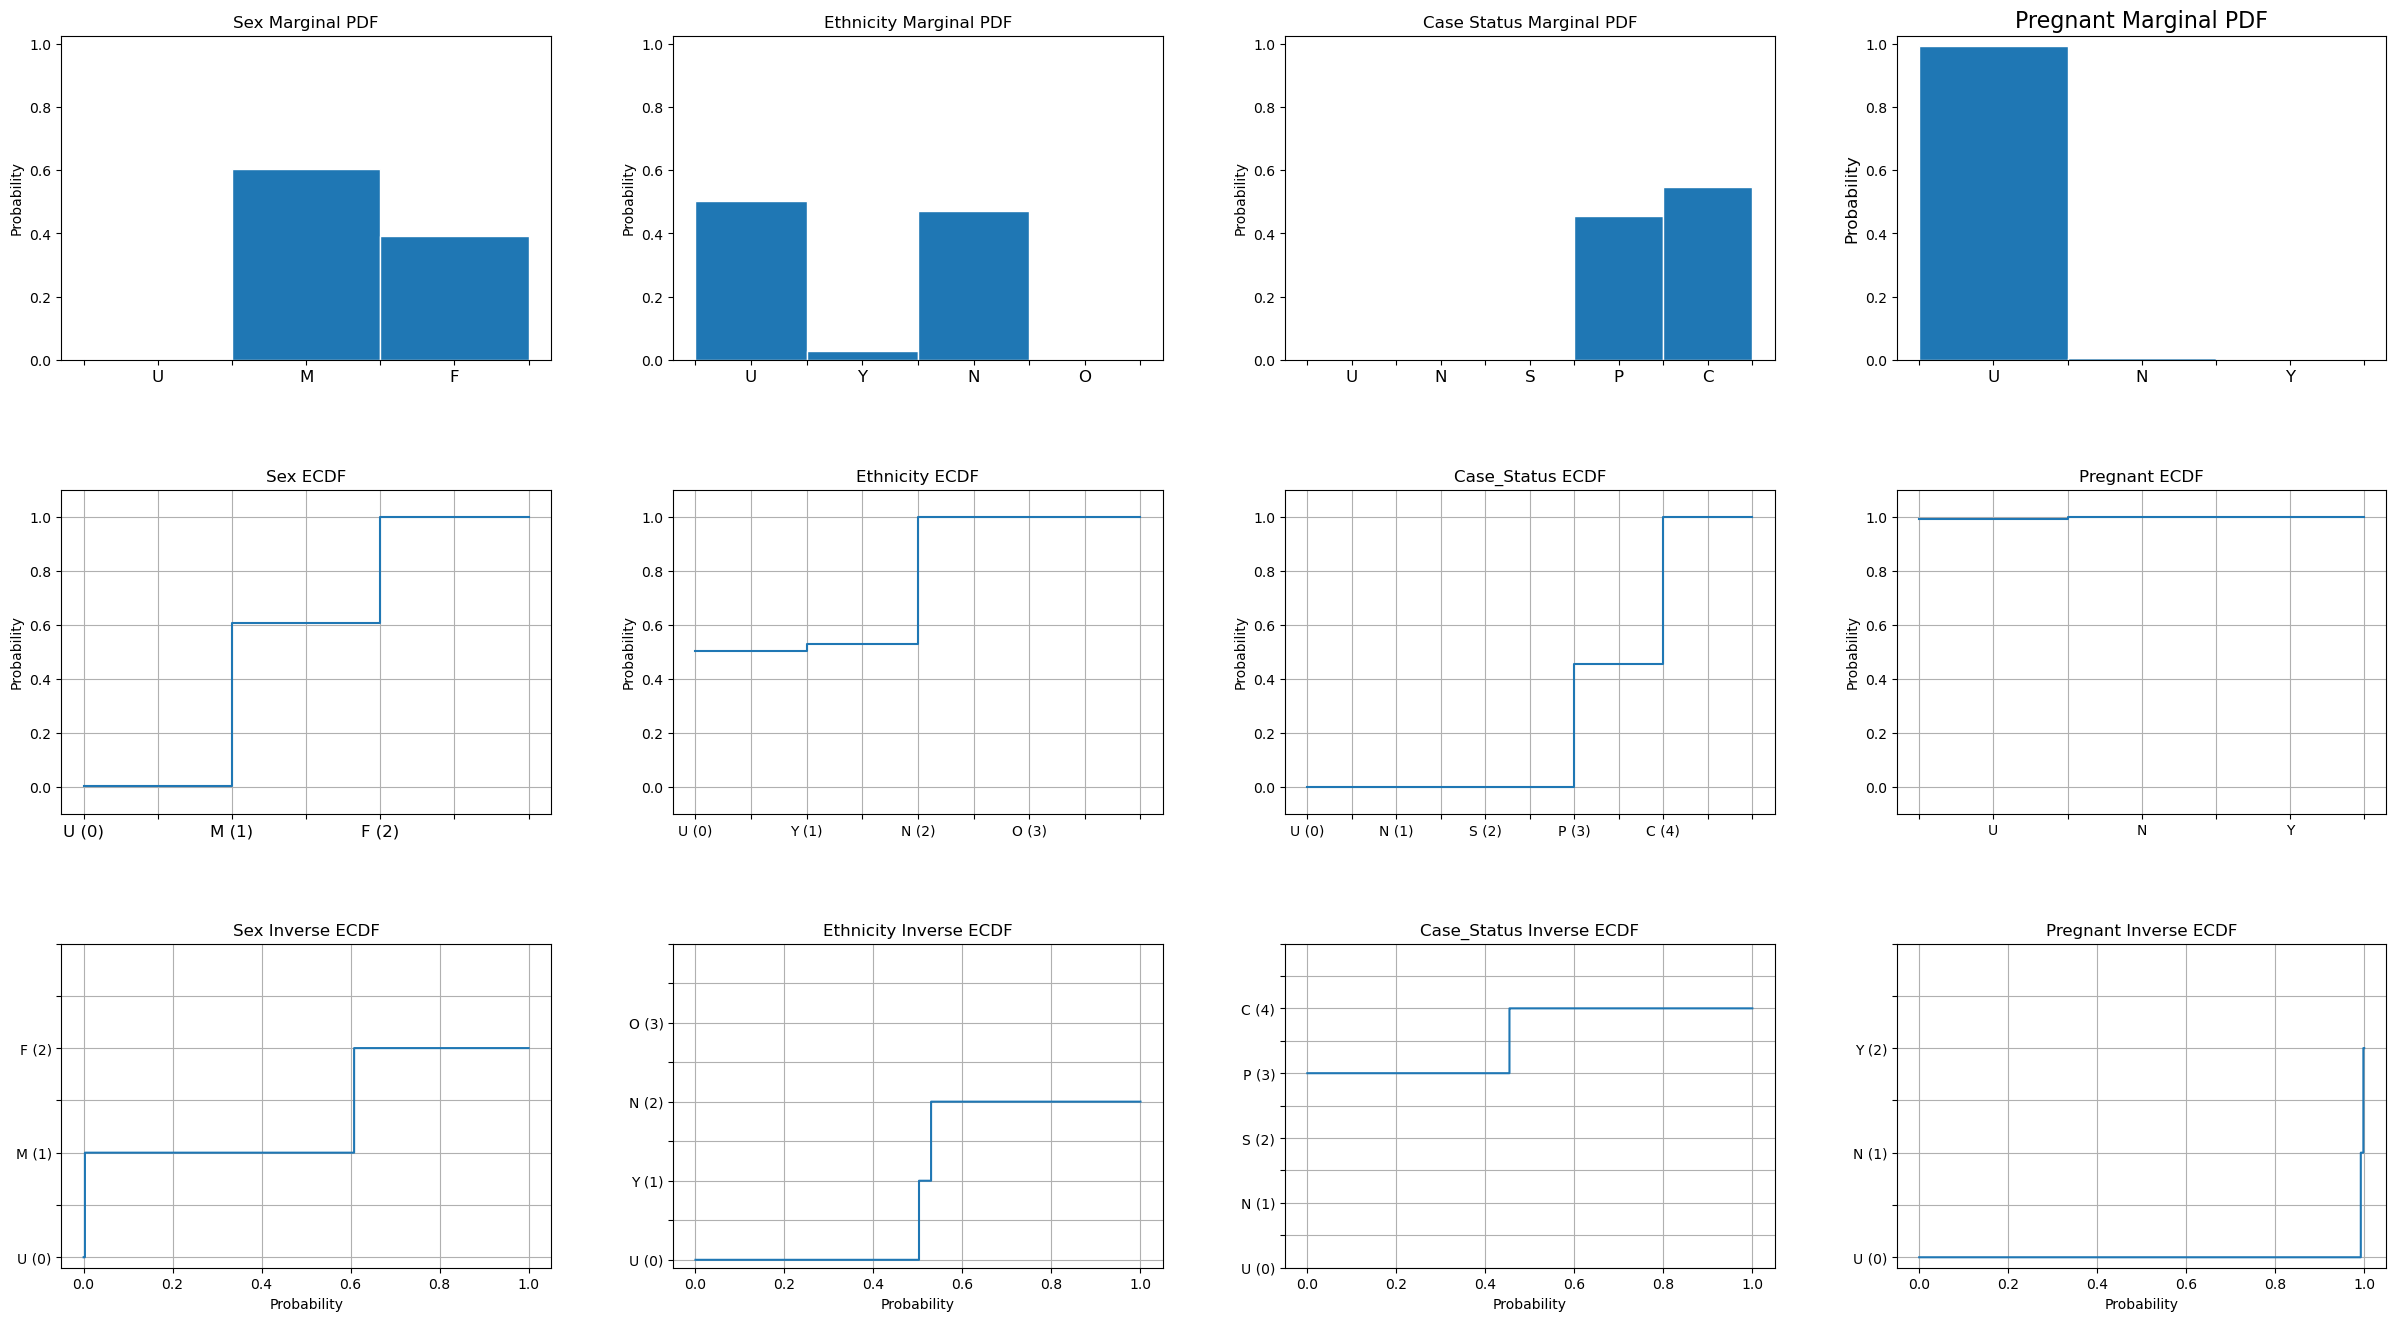

In [31]:
data.plot_pdf_ecdf()

#### Derive the Synthetic Signal from the Synthetic Data

This next code block derives the synthetic signal (number of case reports vs. time) from the synthetic data, using the same techniques as for the original signal above.

In [32]:
# derive a signal from the earliest date in each file_data record
dates, signal_synthetic, maps_synthetic = data.signal_from_anchor_date(file_data)
assert len(signal_synthetic) == len(dates)

# add all the counts in the signal to get the total cases
sample_count_synthetic        = np.sum(signal_synthetic)

print('Timeseries information: ')
print('\t     Sum of all COUNT values: {0}'.format(sample_count_synthetic))
print('\tNumber of days in timeseries: {0}'.format(len(signal_synthetic)))

print('\nDate ranges for each map: ')
for i,m in enumerate(maps_synthetic):
    map_dates = [dt for dt in m.keys()]
    if len(map_dates) > 0:
        sorted_dates = sorted(map_dates)
        m0 = sorted_dates[0]
        m1 = sorted_dates[-1]
        print('\t[{0}]: min: {1},  max: {2}'.format(i, m0, m1))

Found 26550 records with nonzero counts
Number of sorted anchor dates: 1756
Min anchor date: 2015-03-04 00:00:00, max anchor date: 2021-02-07 00:00:00, day_count: 2167
Min date from dates list: 2015-03-04
Max date from dates list: 2021-02-07
Signal information: 
	 min signal value: 0
	 max signal value: 62
	date of max value: 2017-02-21 00:00:00
Timeseries information: 
	     Sum of all COUNT values: 26550
	Number of days in timeseries: 2168

Date ranges for each map: 
	[0]: min: 2015-03-09 00:00:00,  max: 2021-02-21 00:00:00
	[1]: min: 2015-03-06 00:00:00,  max: 2021-02-09 00:00:00
	[2]: min: 2016-05-13 00:00:00,  max: 2020-11-26 00:00:00
	[3]: min: 2015-03-06 00:00:00,  max: 2021-02-09 00:00:00
	[4]: min: 2016-01-04 00:00:00,  max: 2021-01-27 00:00:00
	[5]: min: 2015-03-04 00:00:00,  max: 2021-02-07 00:00:00
	[6]: min: 2015-03-09 00:00:00,  max: 2021-02-21 00:00:00


## Plot the Synthetic Timeseries

Plot the original signal and the synthetic signal loaded from the synthetic data file. This is a check on the signal to see that the dates were generated and written correctly.

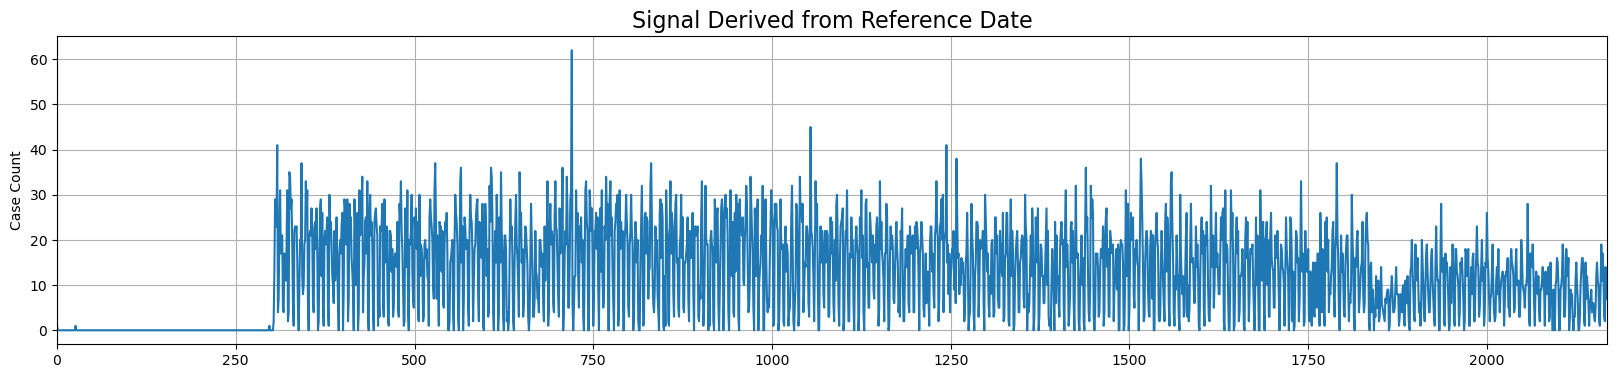

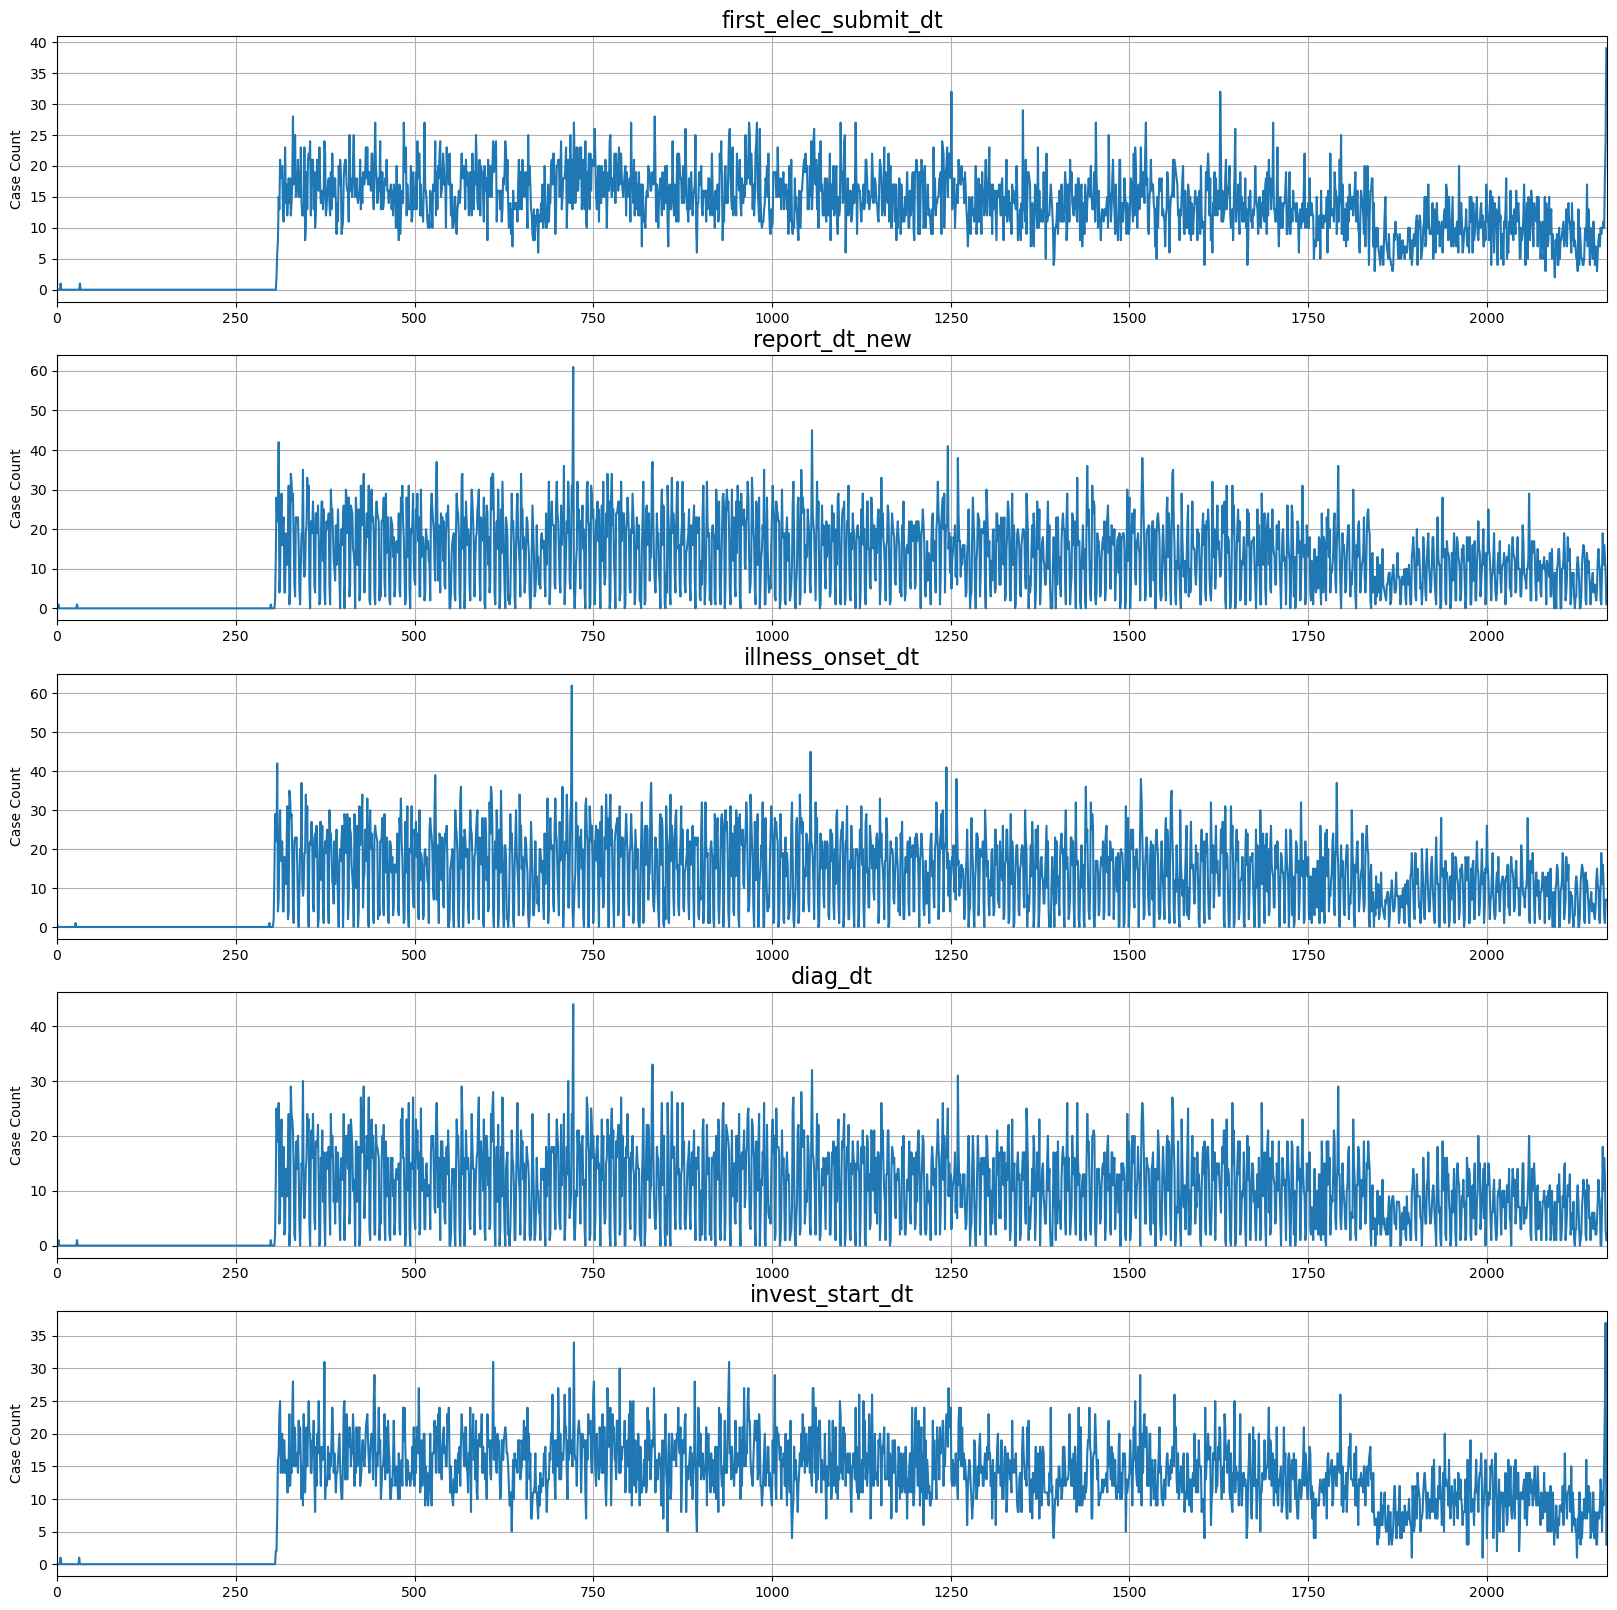

In [33]:
plots.plot_date_signals(dates, signal_synthetic, maps_synthetic)

#### Compute a 6x6 Submatrix of the Kendall's Tau Rank Correlation Matrix for Varying Sample Sizes

With the data loaded, we take slices of length 32, 64, 128, etc. from the synthetic data arrays, compute a 6x6 tau correlation matrix, and save the values of the matrix elements. The variables chosen for the correlation matrix in this section have analogs in the NETSS synthetic data.

In [34]:
# num samples is in the range [2**start, 2**end]
start     = 5    # 32
end       = 18   # 262,144

# key == integer dimension, value = dict of run data for that dimension
result_dict = {}

# generate results for all variables in the model
min_dim = 6
max_dim = 6
for dim in range(min_dim, max_dim+1):
    dim_dict = {}
    dim_dict['runs'] = []

    model_this_run = ' '.join(variable_names[:dim])
    print('MODELSTRING: {0}'.format(model_this_run))

    finished = False
    for i in range(start, end+1):
        if finished:
            break
        run_dict = {}
        n = 2**i
        
        # this is the final run if using all data
        if n > max_samples:
            n = max_samples
            finished = True

        # data for this value of n
        if HL7.NAME_AGE in variable_names[:dim]:
            age_n = age_data[:n]
        if HL7.NAME_SEX in variable_names[:dim]:
            sex_n = sex_data[:n]
        if HL7.NAME_RACE in variable_names[:dim]:
            race_n = race_data[:n]
        if HL7.NAME_ETHNICITY in variable_names[:dim]:
            hispanic_n = hispanic_data[:n]
        if HL7.NAME_CASE_STATUS in variable_names[:dim]:
            casstat_n = casstat_data[:n]            
        if HL7.NAME_COUNTY in variable_names[:dim]:
            county_n = county_data[:n]

        # produce data lists in the order of the variables in the model
        X = []
        for name in variable_names[:dim]:
            if HL7.NAME_AGE == name:
                X.append(age_n)
            if HL7.NAME_SEX == name:
                X.append(sex_n)
            if HL7.NAME_RACE == name:
                X.append(race_n)
            if HL7.NAME_ETHNICITY == name:
                X.append(hispanic_n)
            if HL7.NAME_COUNTY == name:
                X.append(county_n)
            if HL7.NAME_CASE_STATUS == name:
                X.append(casstat_n)

        tau_synthetic = correlation_matrix.kendalls_tau_matrix(X)

        run_dict['X'] = X
        if start == i:
            # initial run, so save original tau matrix computed from source data
            dim_dict['tau_original'] = tau_original

        # save data from this run
        run_dict['n'] = n
        run_dict['tau_synthetic'] = tau_synthetic
        dim_dict['runs'].append(run_dict)
        
        print('\tcompleted n={0}'.format(n))
        
    result_dict[dim] = dim_dict

MODELSTRING: AGE SEX RACE ETHNICITY CASE_STATUS COUNTY
	completed n=32
	completed n=64
	completed n=128
	completed n=256
	completed n=512
	completed n=1024
	completed n=2048
	completed n=4096
	completed n=8192
	completed n=16384
	completed n=26550


#### Plot the Correlation Matrix Elements vs. Sample Size

<b>IMPORTANT</b>: The correlation plots may exhibit a dependence on the random number generator seed. This will emphatically be the case for smaller datasets (a few hundred points or less). Kendall's tau measures rank correlations in the categorical variable values. Different sequences of random numbers will obviously affect these correlations, and the effects are more pronounced for smaller datasets.

The best way to determine whether the copula model preserves rank correlations is to generate more samples and look at the correlation plots. Larger sample counts tend to wash out the spurious correlations that appear in smaller data sets. Be careful if you do this, though: the output file writer will repeat the synthetic timeseries in to the future for sample counts that exceed the number required by the copula model. For very sparse datasets, the maximum HL7 date of `9999-12-31` could be reached, in which case the software will be forced to stop at however many samples it had written at that point.

Convergence is also affected by unbalanced marginal distributions.

The dots in each plot appear at powers of 2 starting with 32, 64, 128, ... up to a maximum of 262144. This produces equally-spaced points on the x-axis, which has a log scale. If the number of synthetic samples is not a power of two, the final point will not appear evenly spaced with the others.

In [35]:
print('Sum of all COUNT values in the synthetic timeseries: {0}'.format(sample_count_synthetic))

Sum of all COUNT values in the synthetic timeseries: 26550


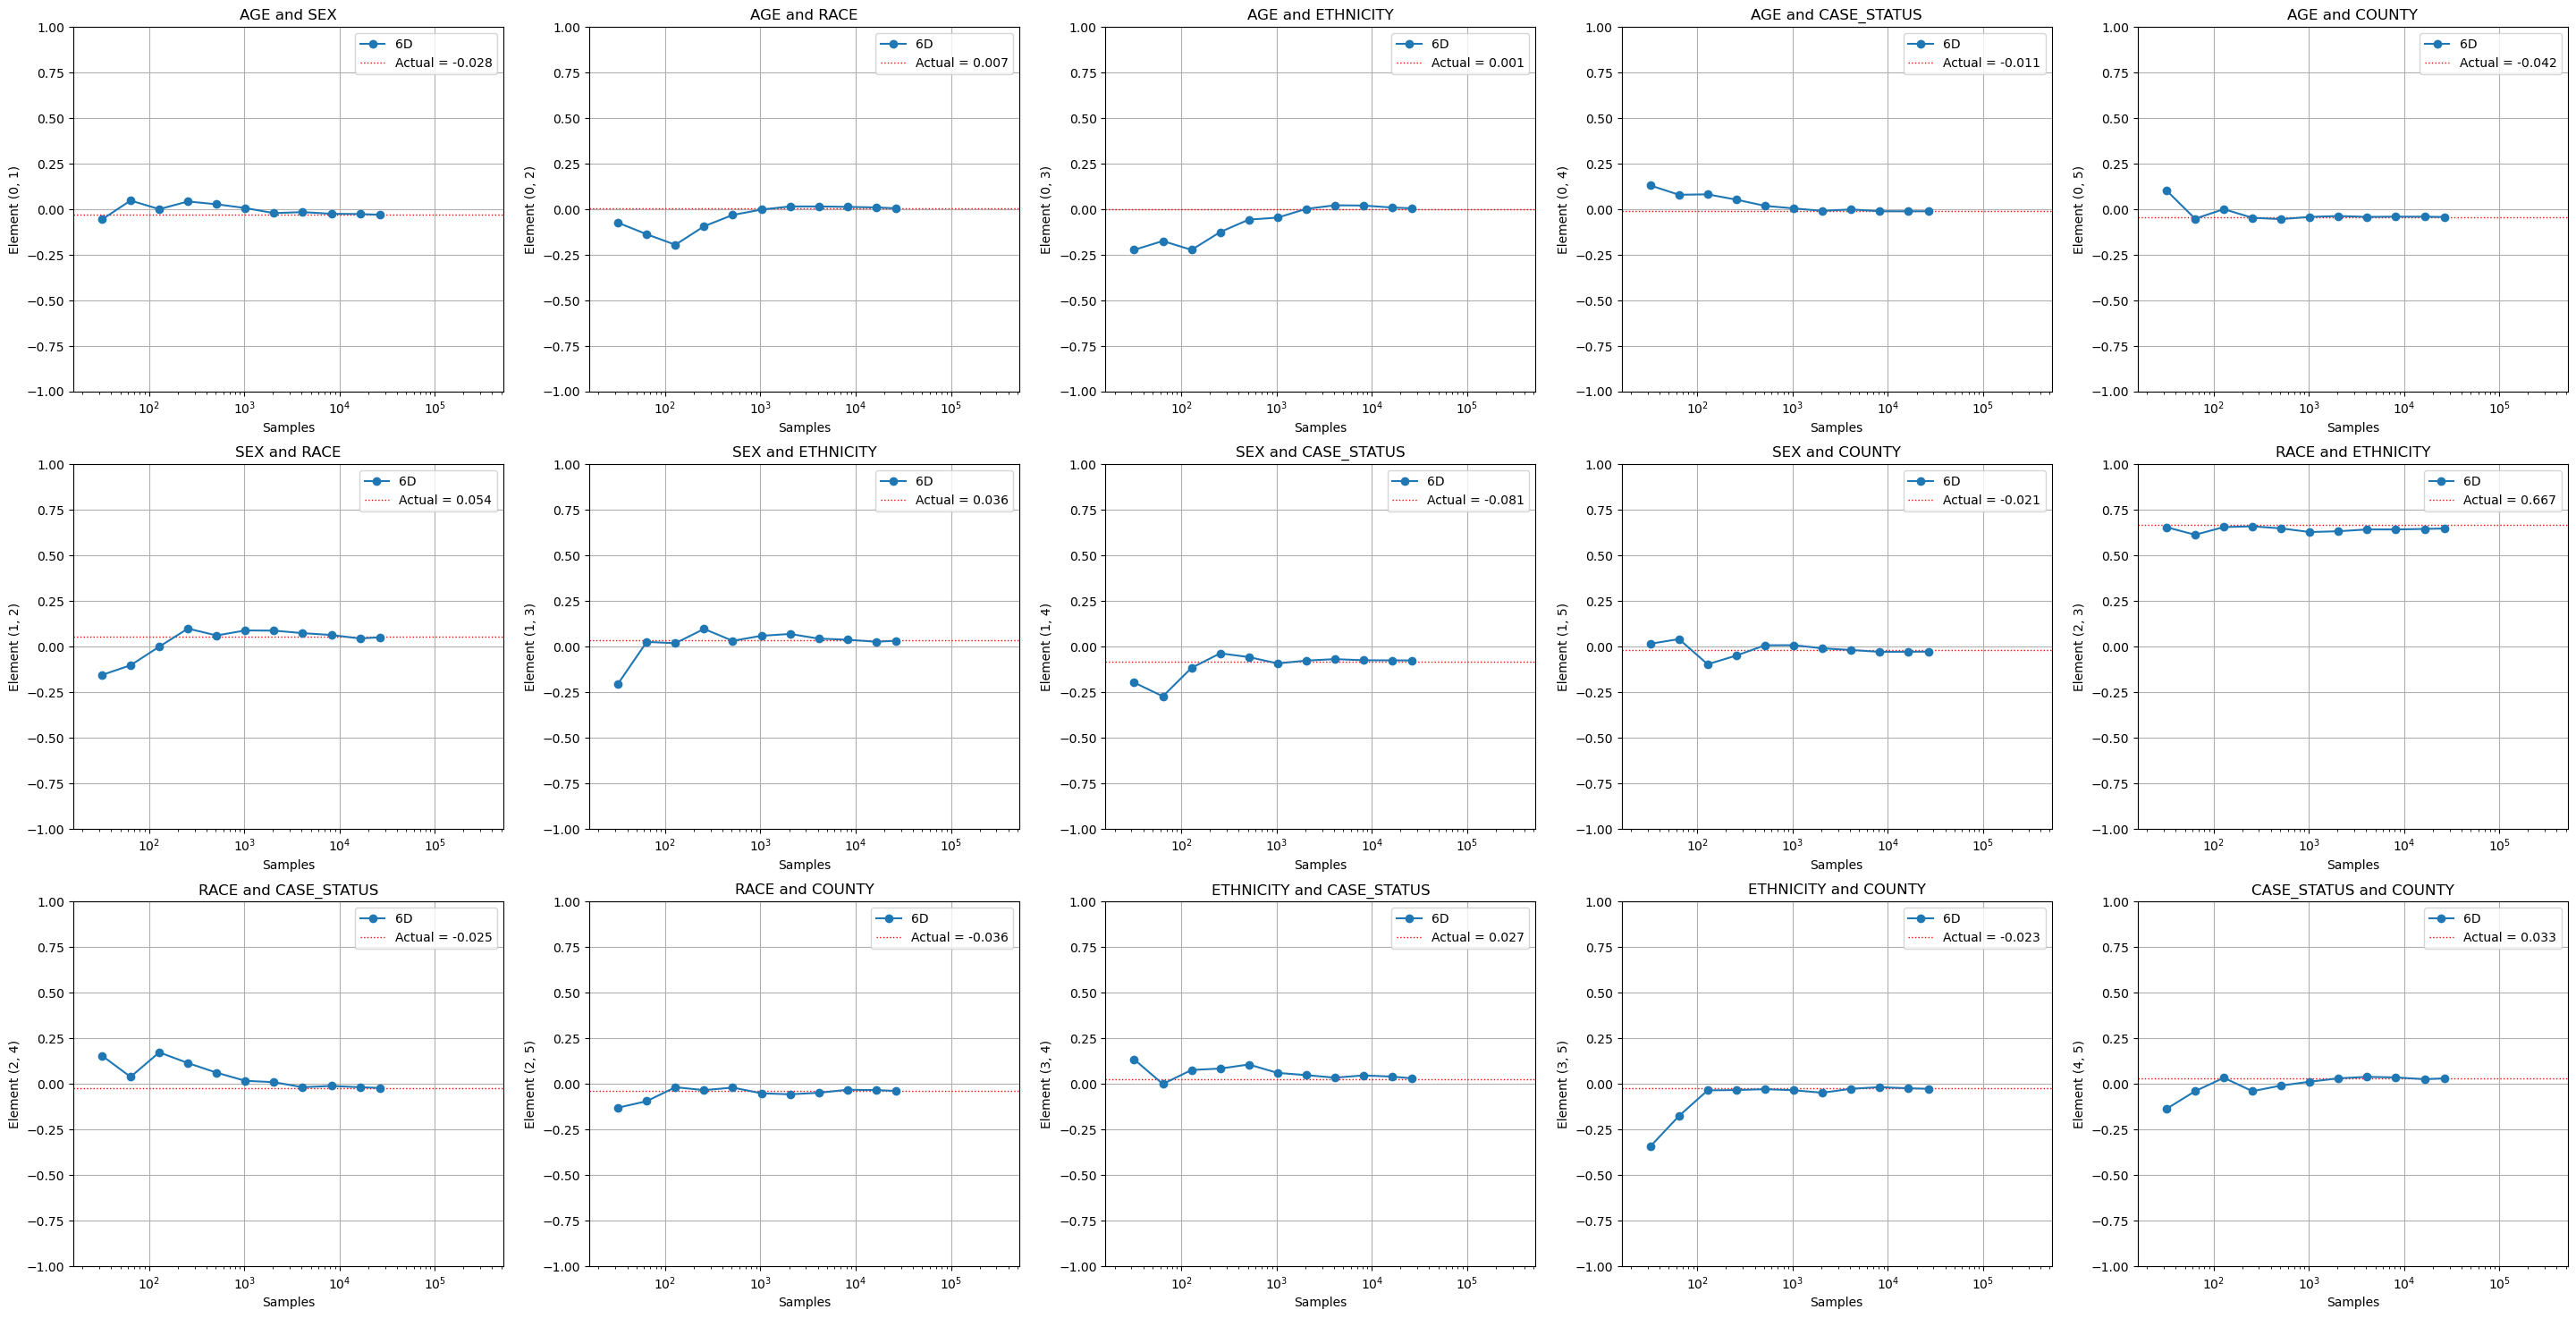

In [36]:
plots.plot_matrix_elements(variable_names, result_dict, min_dim=6, max_dim=6)